In [104]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import fiber
import laser
from joblib import Parallel, delayed
data = np.array([[]])
def gen_data(i, bundle):
    dat = np.array([])
    space = bundle.fiber_rings[i] - bundle.cladding
    bundle.drop_rings((0, i))
    for j in np.linspace(space, 4e-3, 50):
        l = laser.Laser(waist = j, power = 0.09)
        with open("data/20250609/" + str(np.round(l.waist, 5)) + "waist_" + str(i) + "bundlesdropped.csv") as f:
            file = csv.reader(f)
            file.__next__()
            dat = np.append(dat, np.array([*file], dtype = float)).reshape(-1, 3)
            f.close()
    bundle.reset()
    return dat
data = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_data)(i, fiber.FiberBundle(2e-3, 2.5e-5, 5e-5)) for i in range(0, 13))])
data = data.reshape(13, 50, 200, 3)
data[:, :, :, 1] /= 1000

In [105]:
maxes = np.array([])
for i in range(len(data)):
    for j in range(len(data[i])):
        maxes = np.append(maxes, np.max(np.abs(data[i][j][:, 1])))
maxes = maxes.reshape(13, 50)

In [106]:
def gen_headers(i, bundle):
    head = np.array([])
    space = bundle.fiber_rings[i] - bundle.cladding
    bundle.drop_rings((0, i))
    for j in np.linspace(space, 4e-3, 50):
        l = laser.Laser(waist = j, power = 0.09)
        with open("data/20250609/" + str(np.round(l.waist, 5)) + "waist_" + str(i) + "bundlesdropped.csv") as f:
            file = csv.reader(f)
            head = np.append(head, file.__next__())
            f.close()
    bundle.reset()
    return head
headers = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_headers)(i, fiber.FiberBundle(2e-3, 2.5e-5, 5e-5)) for i in range(0, 13))])
headers = headers.reshape(13, 50, 12)

In [107]:
w = np.array([])
for c in headers[:, :, 6]:
    for waist in c:
        w = np.append(w, float(waist[13:]))
w = w.reshape(13, 50)

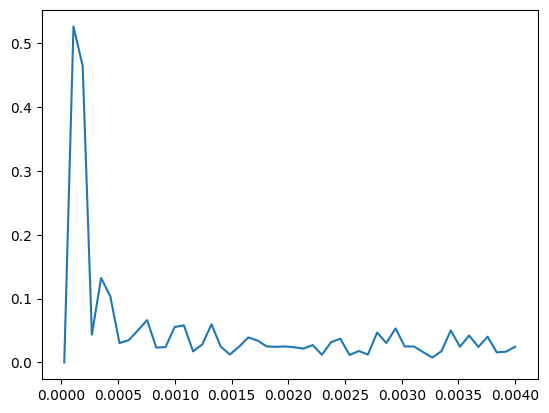

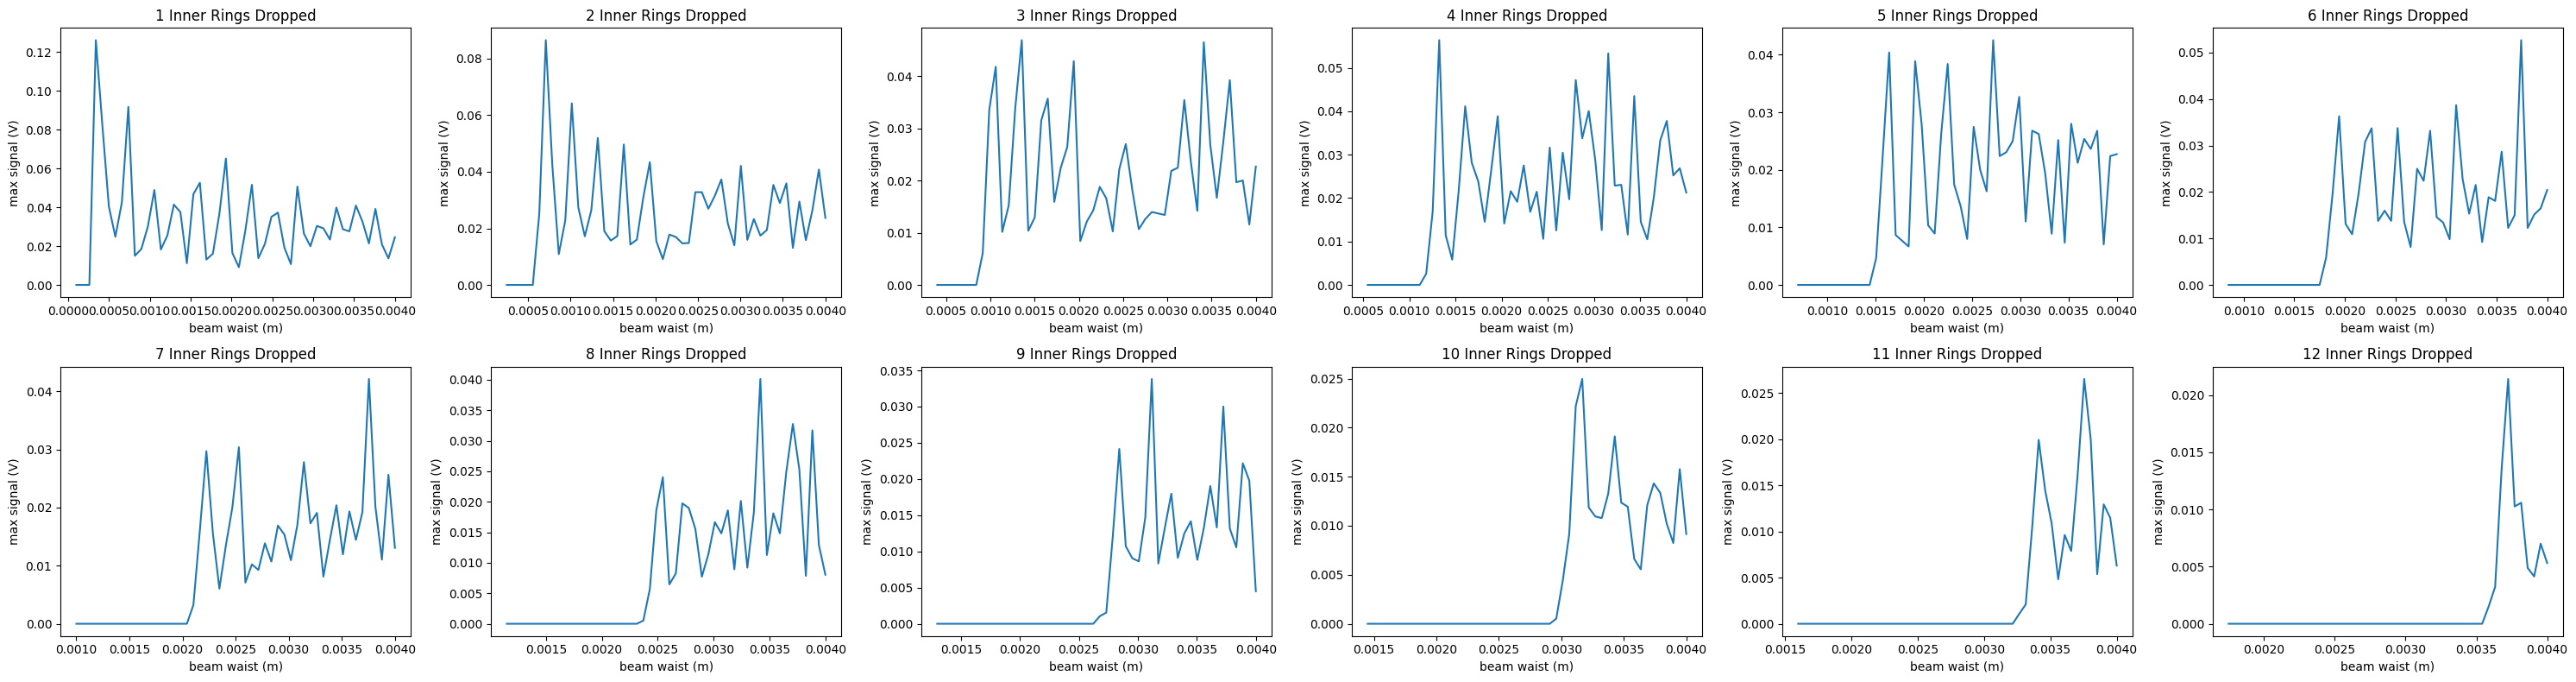

In [108]:
scale = 1668
plt.plot(w[0], maxes[0] * scale)
plt.show()
fig, ax = plt.subplots(2, 6, figsize = (30, 8))
for i in range(1, 13):
    if i < 7:
        ax[0][i - 1].plot(w[i], maxes[i] * scale, label = "rings dropped = " + str(i))
        ax[0][i - 1].set_xlabel("beam waist (m)")
        ax[0][i - 1].set_ylabel("max signal (V)")
        ax[0][i - 1].set_title(str(i) + " Inner Rings Dropped")
    else:
        ax[1][i - 7].plot(w[i], maxes[i] * scale, label = "rings dropped = " + str(i))
        ax[1][i - 7].set_xlabel("beam waist (m)")
        ax[1][i - 7].set_ylabel("max signal (V)")
        ax[1][i - 7].set_title(str(i) + " Inner Rings Dropped")
plt.tight_layout()
plt.show()

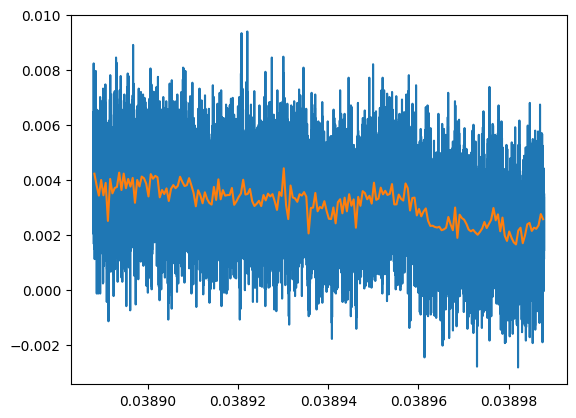

In [109]:
import sys
sys.path.append("../../lhillber/brownian/src")
import os
from nptdms import TdmsFile
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    # Returns a list of args, and traces
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        # print("Reading ", folder_name, str(i))
        # print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }
def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    # print("Sample rate is " + str(sample_rate))
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    ret = np.mean(series.reshape(-1, bin_size), axis=1)
    return ret

traces = check_and_load_or_process(176, "../data/sample_noise/", "X", 1, 5)
times = np.arange(0, len(traces[0]['series'])) * (1 / TdmsFile.read("../data/sample_noise/iter_176.tdms")["main"].properties.get("r", None))
mx_t = times[-1] * np.random.rand()
trace = int(np.round(np.random.rand() * 4))
plt.plot(times[find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], traces[trace]["series"][find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)])
plt.plot(bin_data(times[find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], 100), bin_data(traces[trace]["series"][find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], 100))
plt.show()

In [110]:
from scipy.signal import periodogram
def gen_freqs(i, j):
    return periodogram(data[i][j][:, 1] * scale, 2e6, nfft = len(data[i][j][:, 1]))[0]
def gen_sigs(i, j):
    return periodogram(data[i][j][:, 1] * scale, 2e6, nfft = len(data[i][j][:, 1]))[1]
def gen_noises(i, j, mx_t, trace):
    return periodogram(bin_data(traces[trace]["series"][find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], 100), 2e6, nfft = len(data[i][j][:, 1]))[1]
def gen_psds(i, j, mx_t, trace):
    return periodogram(data[i][j][:, 1] * scale + bin_data(traces[trace]["series"][find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], 100), 2e6, nfft = len(data[i][j][:, 1]))[1]
mx_t = ((times[-1] - 1e-4) * np.random.rand()) + 1e-4
trace = int(np.round(np.random.rand() * 4))
sigs = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_sigs)(i, j) for i in range(len(data)) for j in range(len(data[i])))])
noises = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_noises)(i, j, mx_t, trace) for i in range(len(data)) for j in range(len(data[i])))])
freqs= np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_freqs)(i, j) for i in range(len(data)) for j in range(len(data[i])))])
psds = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_psds)(i, j, mx_t, trace) for i in range(len(data)) for j in range(len(data[i])))])
freqs = freqs.reshape(13, 50, -1)
psds = psds.reshape(13, 50, -1)
sigs = sigs.reshape(13, 50, -1)
noises = noises.reshape(13, 50, -1)

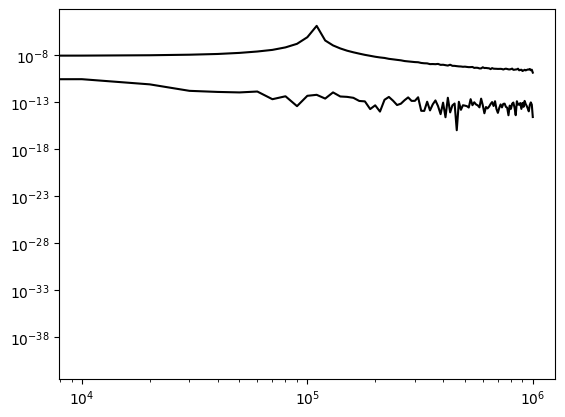

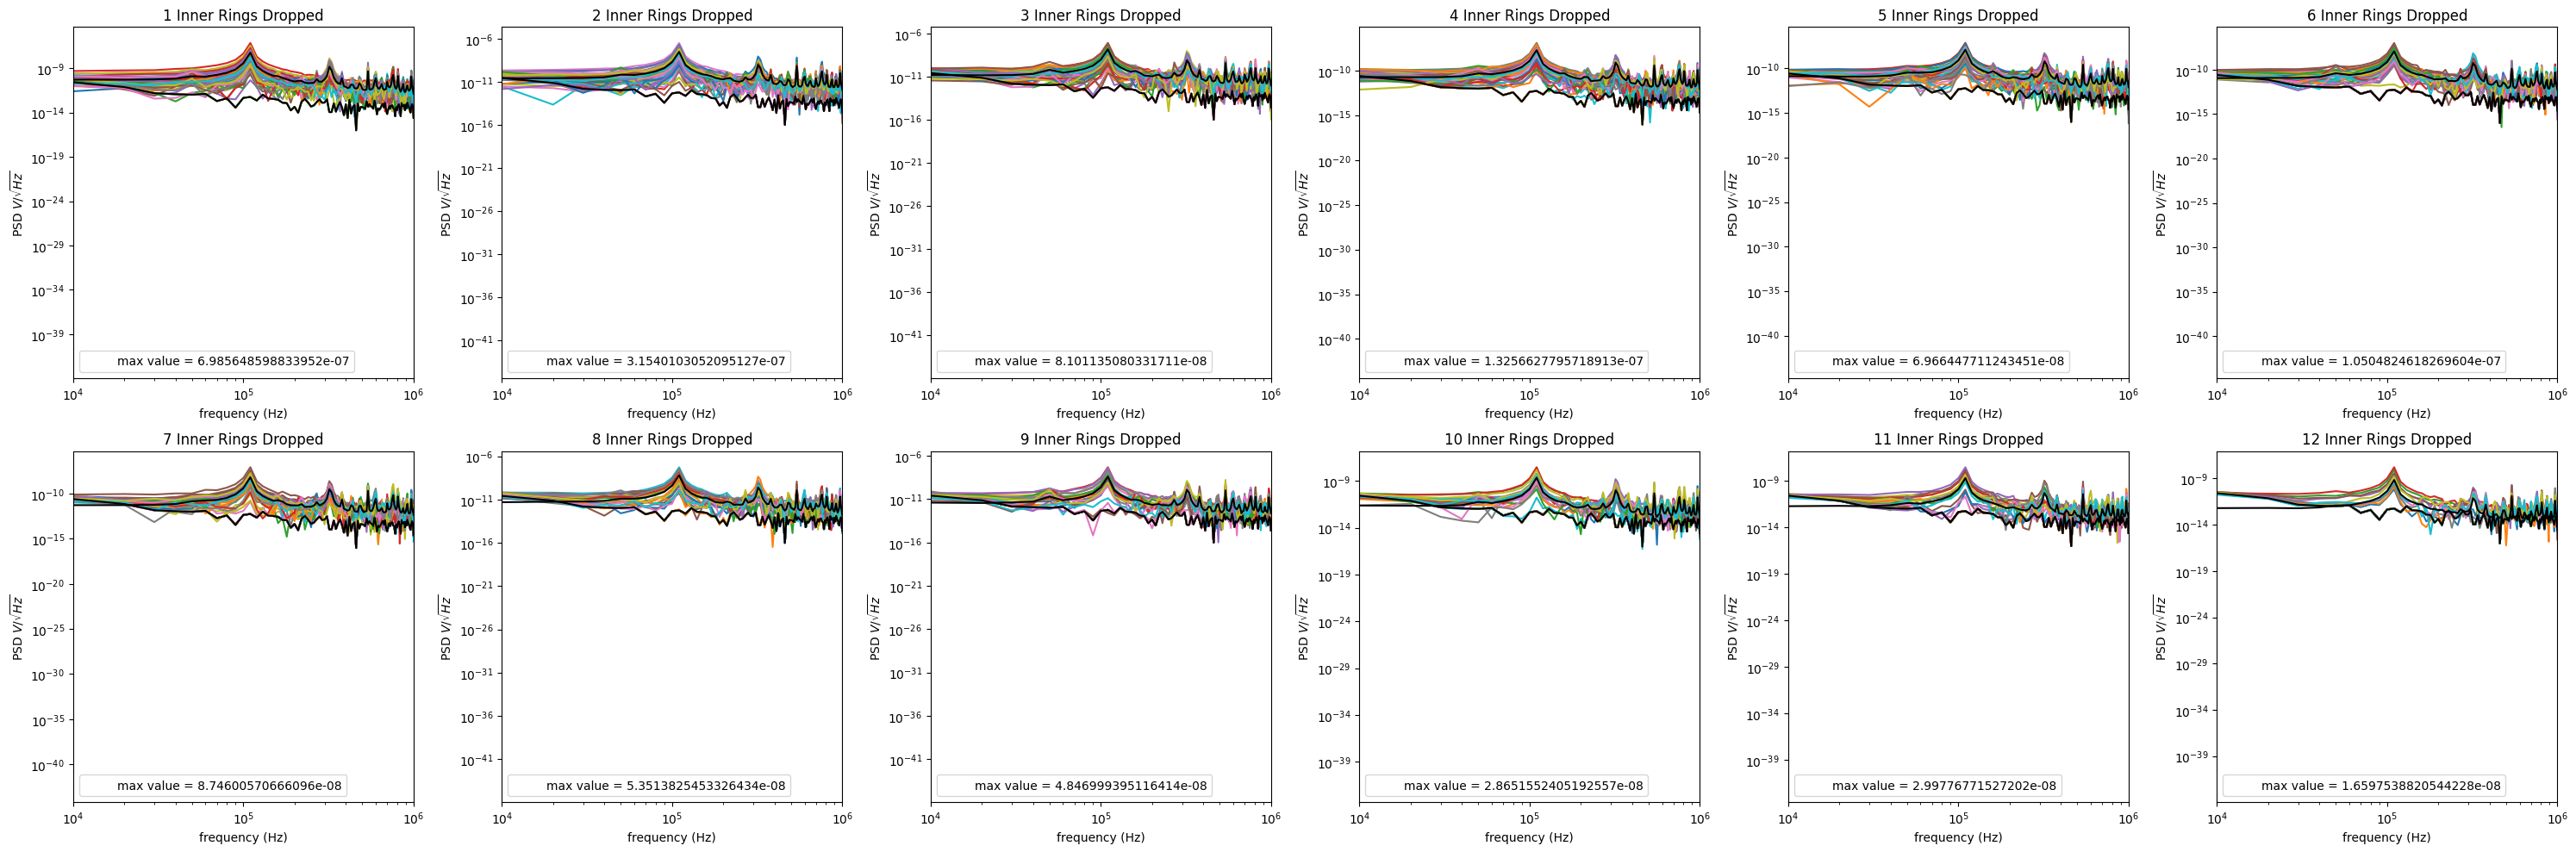

In [111]:
import matplotlib
# plt.loglog(np.mean(freqs[:], axis = 1)[0], np.mean(sigs[:], axis = 1)[0], c = "k")
# plt.loglog(np.mean(freqs[:], axis = 1)[0], np.mean(noises[:], axis = 1)[0], c = "k")
# plt.show()
plt.loglog(freqs[0][1], sigs[0][1], c = "k")
plt.loglog(freqs[0][1], noises[0][1], c = "k")
plt.show()
fig, ax = plt.subplots(2, 6, figsize = (30, 10))
for i in range(1, 13):
    for j in range(len(psds[i])):
        if i < 7:
            ax[0][i - 1].loglog(freqs[i][j], psds[i][j])
        else:
            ax[1][i - 7].loglog(freqs[i][j], psds[i][j])
    if i < 7:
        # ax[0][i - 1].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(psds[:], axis = 1)[i], c = "k")
        ax[0][i - 1].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(sigs[:], axis = 1)[i], c = "k")
        ax[0][i - 1].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(noises[:], axis = 1)[i], c = "k")
        ax[0][i - 1].set_title(str(i) + " Inner Rings Dropped")
        ax[0][i - 1].set_xlabel("frequency (Hz)")
        ax[0][i - 1].set_ylabel(r"PSD $V / \sqrt{Hz}$")
        ax[0][i - 1].set_xlim(1e4, 1e6)
        # ax[0][i - 1].set_ylim(1e-15, 1e-4)
        r = matplotlib.patches.Rectangle((0,0), 0.001, 0.001, fill=False, edgecolor='none', visible=False)
        ax[0][i - 1].legend([r], ["max value = " + str(np.max(psds[i]))])
    else:
        # ax[1][i - 7].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(psds[:], axis = 1)[i], c = "k")
        ax[1][i - 7].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(sigs[:], axis = 1)[i], c = "k")
        ax[1][i - 7].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(noises[:], axis = 1)[i], c = "k")
        ax[1][i - 7].set_title(str(i) + " Inner Rings Dropped")
        ax[1][i - 7].set_xlabel("frequency (Hz)")
        ax[1][i - 7].set_ylabel(r"PSD $V / \sqrt{Hz}$")
        ax[1][i - 7].set_xlim(1e4, 1e6)
        # ax[1][i - 7].set_ylim(1e-15, 1e-4)
        r = matplotlib.patches.Rectangle((0,0), 0.001, 0.001, fill=False, edgecolor='none', visible=False)
        ax[1][i - 7].legend([r], ["max value = " + str(np.max(psds[i]))])
plt.tight_layout()
plt.show()

In [112]:
snrs = np.array([])
for i in range(0, 13):
    for j in range(len(sigs[i])):
        if np.sum(sigs[i][j]) == 0:
            snrs = np.append(snrs, 0)
        else:
            snrs = np.append(snrs, 10 * np.log10(np.sum(sigs[i][j]) / np.sum(noises[i][j])))
snrs = snrs.reshape(13, 50)

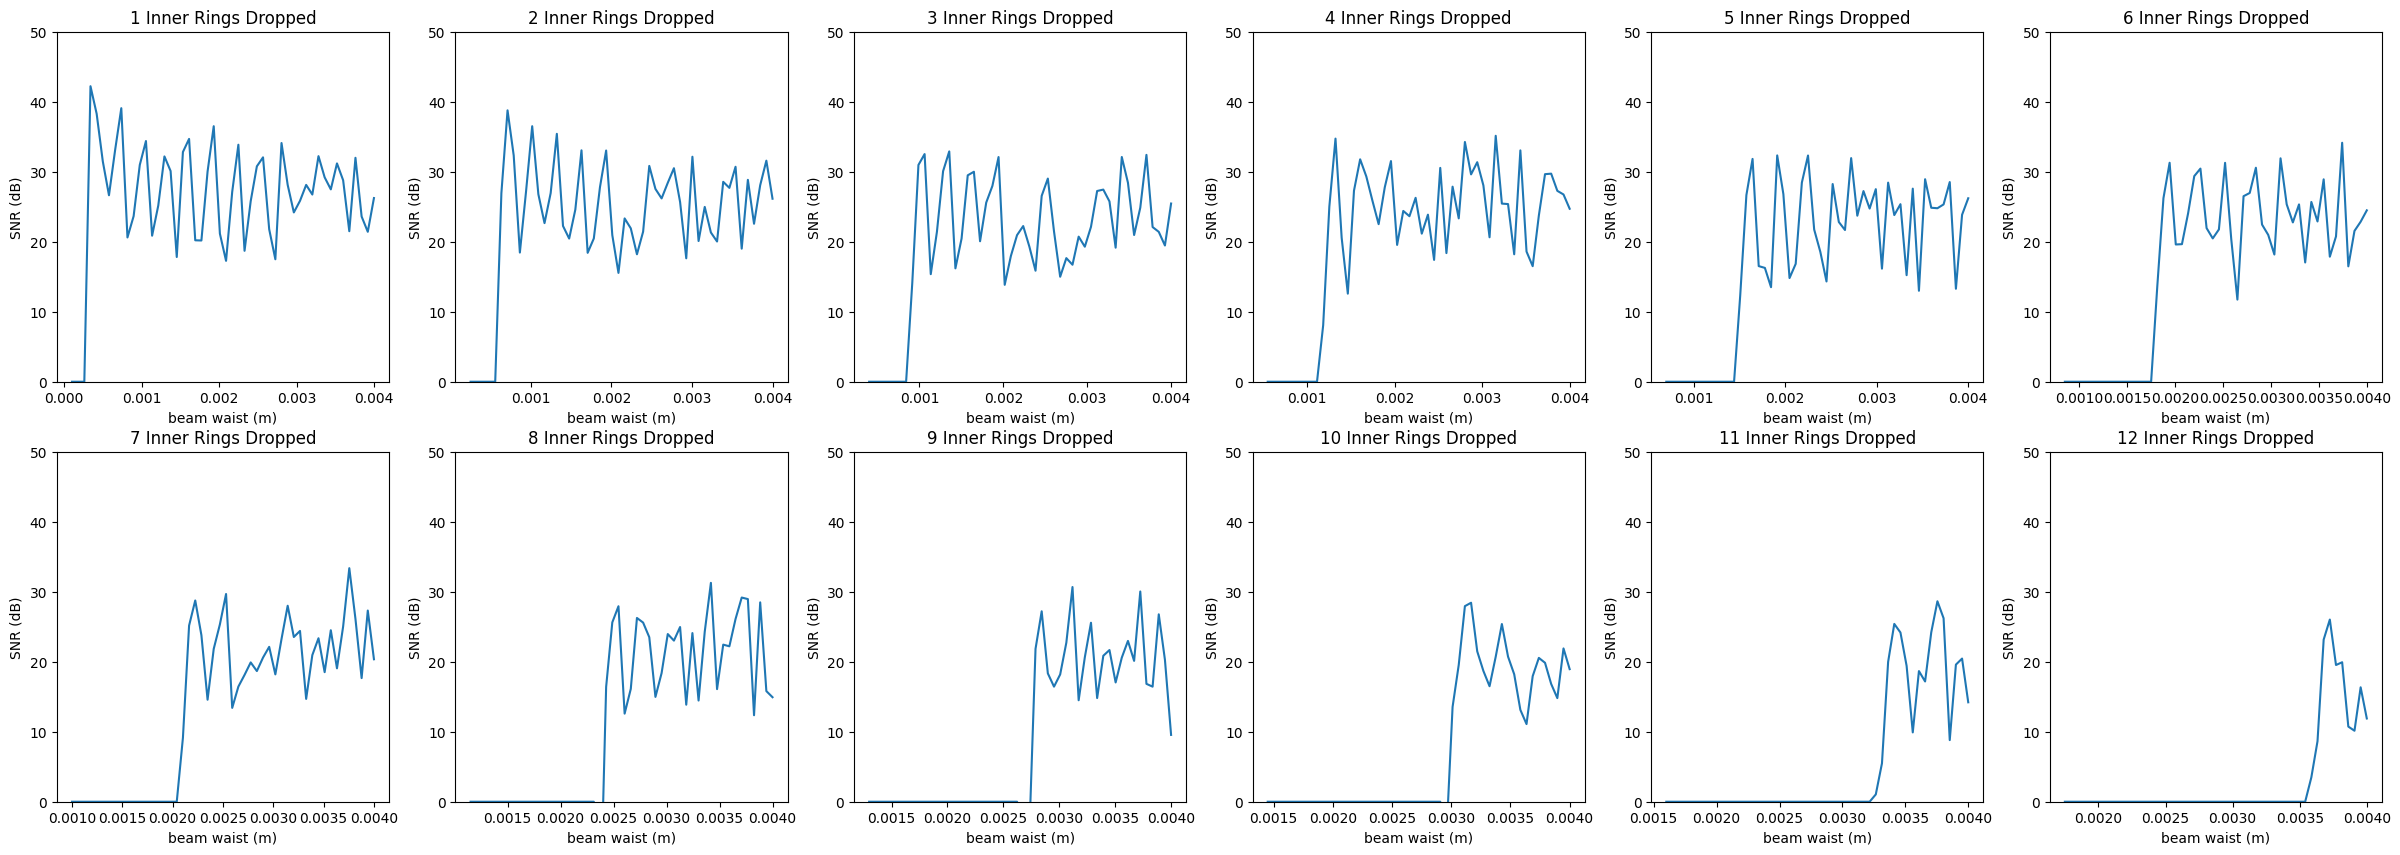

In [113]:
best_snr_waist = np.array([])
best_snr_waist = np.append(best_snr_waist, w[0][np.where(snrs[0] == np.max(snrs[0]))[0]])
fig, ax = plt.subplots(2, 6, figsize = (30, 10))
for i in range(1, 13):
    best_snr_waist = np.append(best_snr_waist, w[i][np.where(snrs[i] == np.max(snrs[i]))[0]])
    if i < 7:
        ax[0][i - 1].plot(w[i], snrs[i])
        ax[0][i - 1].set_xlabel("beam waist (m)")
        ax[0][i - 1].set_ylabel("SNR (dB)")
        ax[0][i - 1].set_title(str(i) + " Inner Rings Dropped")
        ax[0][i - 1].set_ylim(0, 50)
    else:
        ax[1][i - 7].plot(w[i], snrs[i])
        ax[1][i - 7].set_xlabel("beam waist (m)")
        ax[1][i - 7].set_ylabel("SNR (dB)")
        ax[1][i - 7].set_title(str(i) + " Inner Rings Dropped")
        ax[1][i - 7].set_ylim(0, 50)
plt.show()

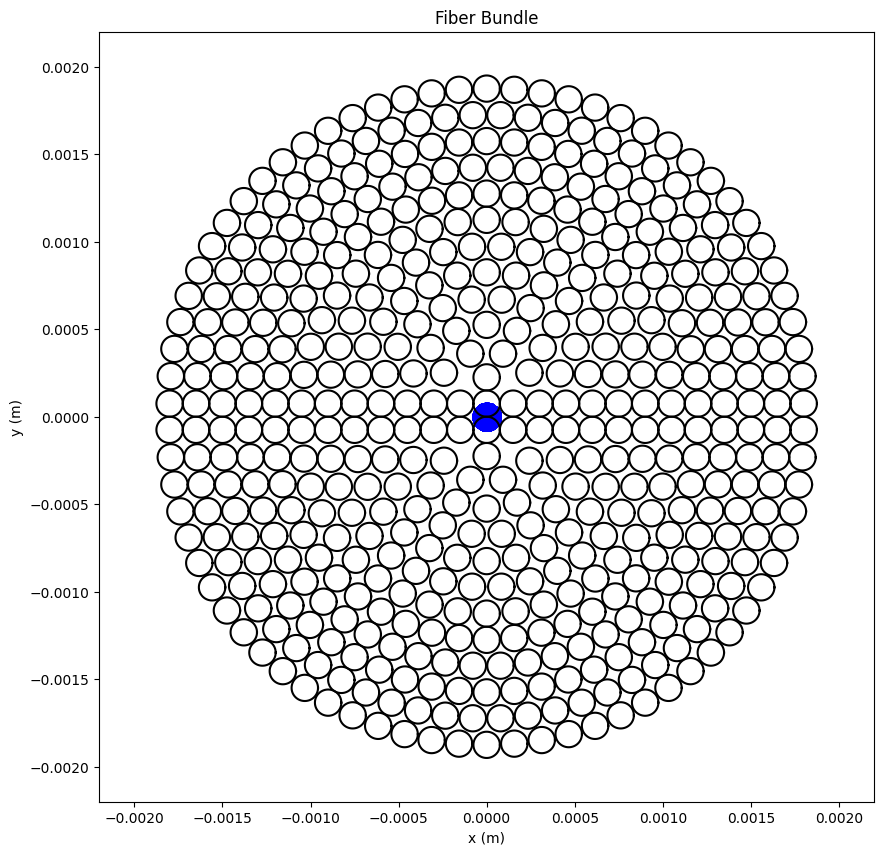

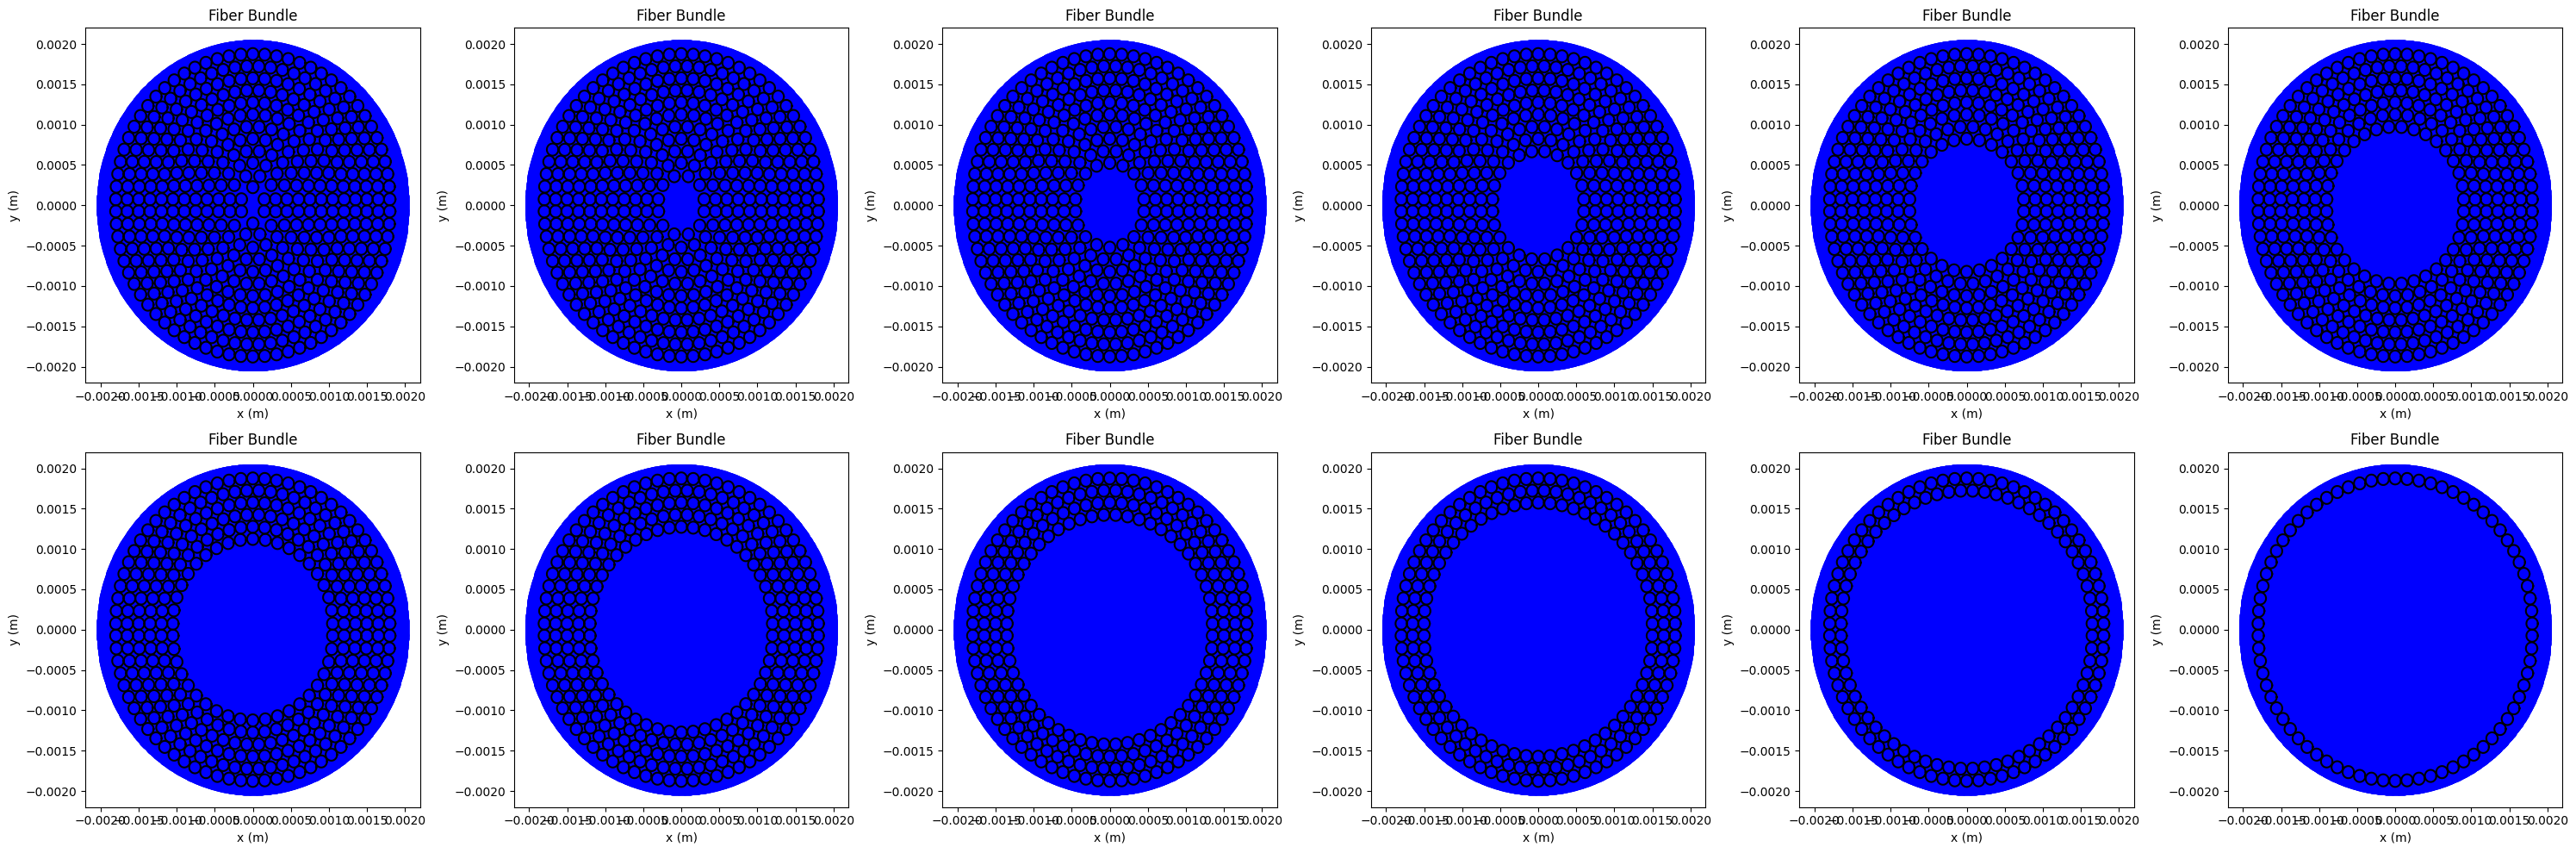

[0.00010612 0.00033878 0.00070918 0.0013551  0.0031551  0.00191224
 0.00374286 0.0037551  0.00341837 0.00311837 0.00316735 0.0037551
 0.00372449]


In [115]:
bundle = fiber.FiberBundle(2e-3, 2.5e-5, 5e-5)
bundle.plot(im = laser.Laser(waist = best_snr_waist[0], power = 90), show = True, c = "k")
fig, ax = plt.subplots(2, 6, figsize = (30, 10))
for i in range(1, 13):
    bundle = fiber.FiberBundle(2e-3, 2.5e-5, 5e-5)
    bundle.drop_rings((0, i))
    # l = laser.Laser(waist = best_snr_waist[i], power = 90)
    l = laser.Laser(waist = w[i][-1], power = 90)
    bundle.plot(ax = ax[(i - 1) // 6][(i - 1) % 6], im = l, c = "k")
plt.tight_layout()
plt.show()
print(best_snr_waist)

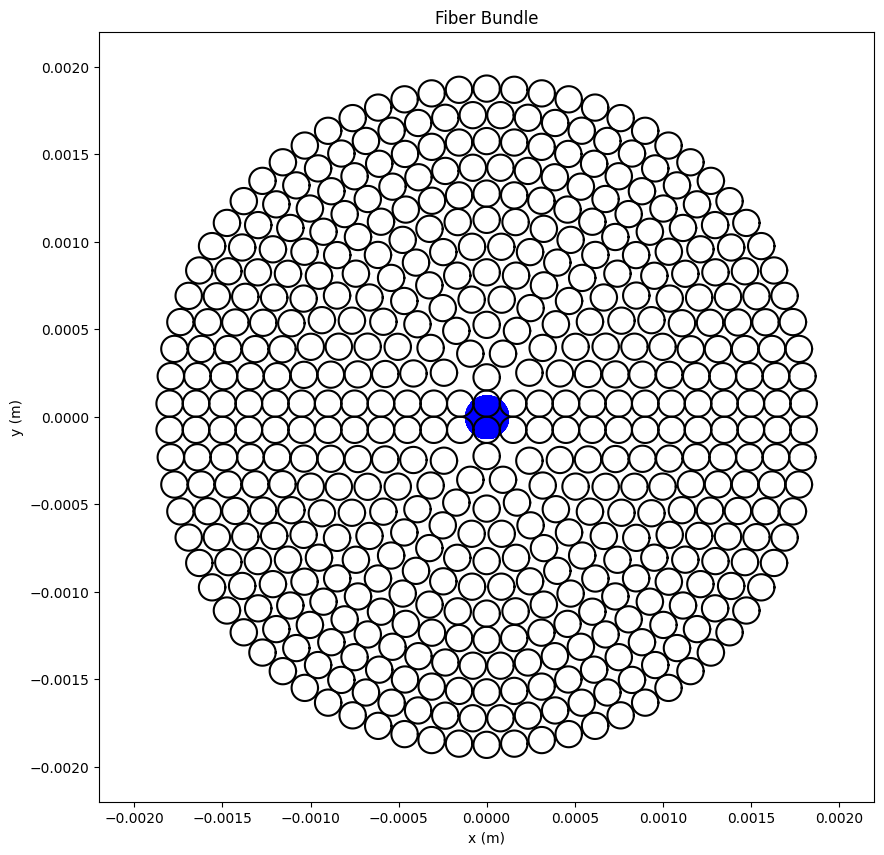

IndexError: index 9 is out of bounds for axis 0 with size 9

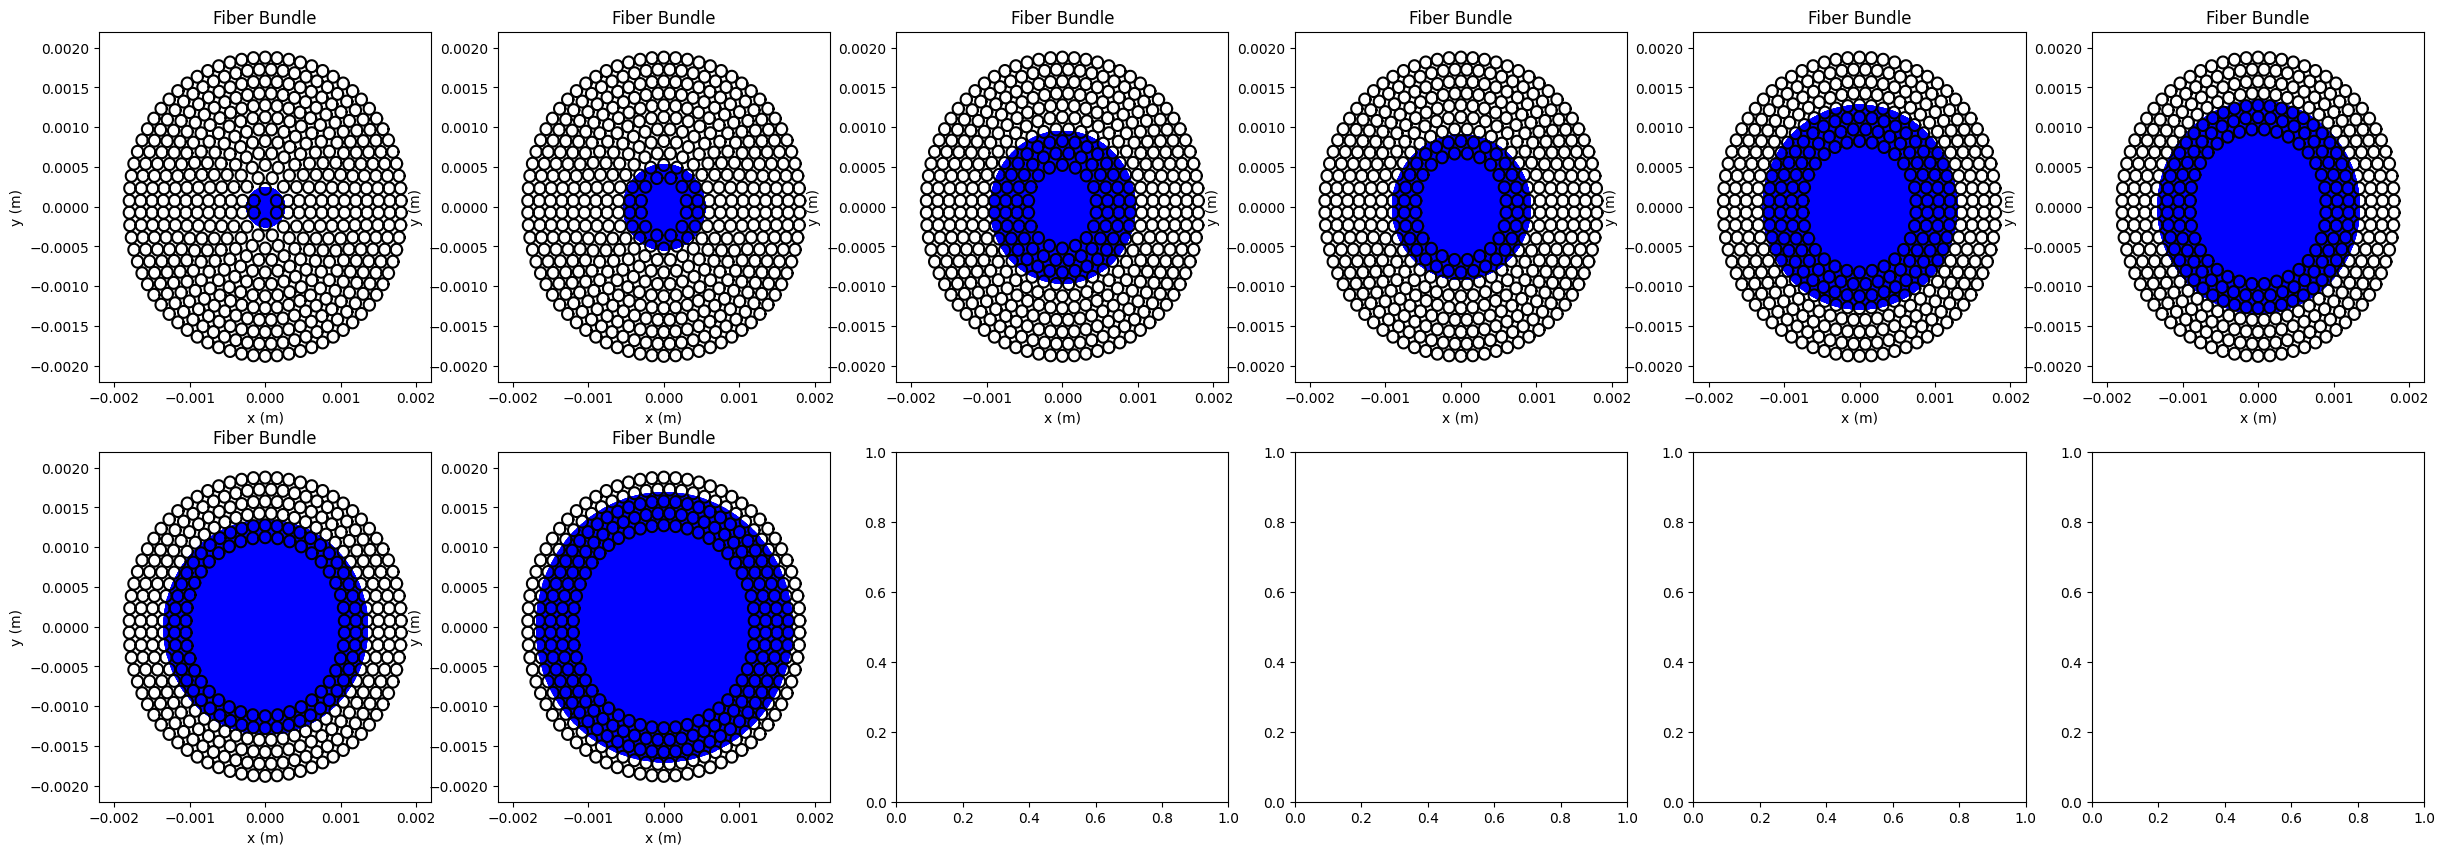

In [60]:
bundle = fiber.FiberBundle(2e-3, 2.5e-5, 5e-5)
bundle.plot(im = laser.Laser(waist = best_snr_waist[0], power = 90), show = True, c = "k")
fig, ax = plt.subplots(2, 6, figsize = (30, 10))
for i in range(1, 13):
    bundle = fiber.FiberBundle(2e-3, 2.5e-5, 5e-5)
    bundle.drop_rings((0, i))
    l = laser.Laser(waist = best_snr_waist[i], power = 90)
    bundle.plot(ax = ax[(i - 1) // 6][(i - 1) % 6], im = l, c = "k")
plt.tight_layout()
plt.show()
print(best_snr_waist)

In [39]:
print(best_snr_waist)
from scipy.signal import periodogram
def gen_noises(trace):
    return periodogram(traces[trace]["series"][:], TdmsFile.read("../data/sample_noise/iter_176.tdms")["main"].properties.get("r", None), nfft = len(times))
f, noises = gen_noises(0)
def find_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
print(noises[find_idx(f, 1.55e6)])

[0.00010612 0.00033878 0.00070918 0.0013551  0.0031551  0.00191224
 0.00374286 0.0037551  0.00341837 0.00311837 0.00316735 0.0037551
 0.00372449]
2.6778519343360177e-14


In [35]:
import numpy as np
import csv
import matplotlib.pyplot as plt

with open("data/20250612/NEP.csv") as f:
    file = csv.reader(f)
    data = np.array([*file], dtype = float)
    f.close()
data = data.reshape(13, -1, 2, 3)

In [ ]:
from scipy.signal import periodogram
mx_t = ((times[-1] - 1e-4) * np.random.rand()) + 1e-4
trace = int(np.round(np.random.rand() * 4))
plt.plot(data[:, 0], data[:, 1])
plt.plot(data[:, 0], data[:, 1] * 30e3)
plt.plot(np.linspace(0, 0.0001, 200), bin_data(traces[trace]["series"][find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], 100))
plt.show()
f, x = periodogram(data[:, 1] * 30e3, 2e6, nfft = len(data[:, 2]))
s = sum(x)
plt.loglog(f, x)
# x = np.full((101), 1e-17)
n = np.sum(x)
plt.loglog(f, x)
# plt.ylim(1e-20, 1e-9)
plt.show()
print(10 * np.log10(s / n))

In [77]:
bundle = fiber.FiberBundle(2e-3, 2.5e-5, 5e-5)
print(waists[7] / (bundle.r * 2))
print((bundle.fiber_rings[7] - bundle.cladding) / bundle.r)

0.9387749999999999
0.5000000000000001


[5.33669923e-10 1.35304777e-09 5.99484250e-10 3.27454916e-11
 4.22924287e-10 9.54548457e-10 5.85702082e-11 7.56463328e-10
 1.35304777e-09 1.51991108e-09 1.51991108e-09 7.56463328e-10
 1.23284674e-08]


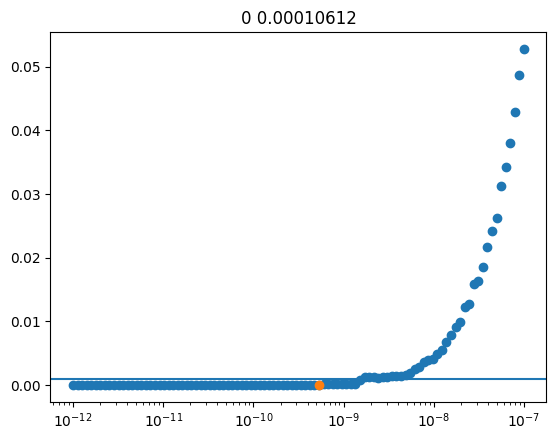

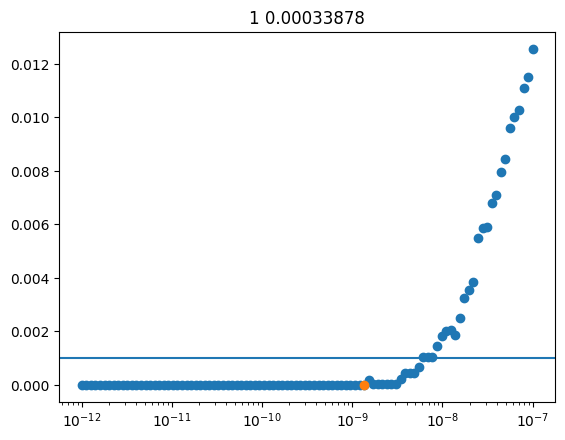

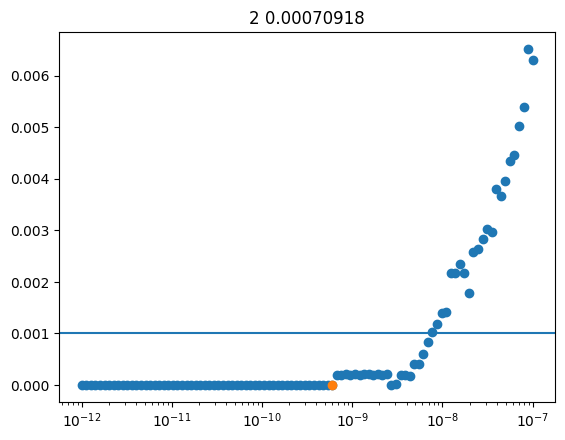

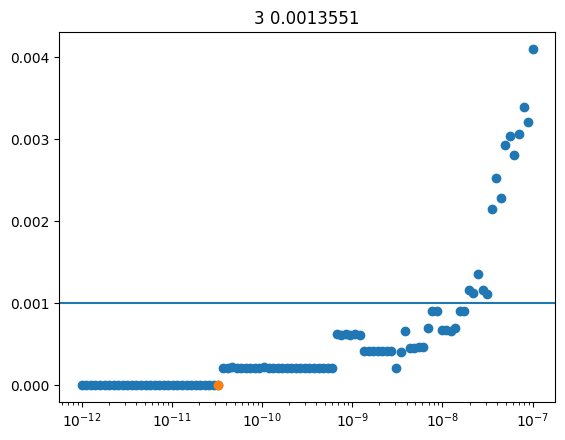

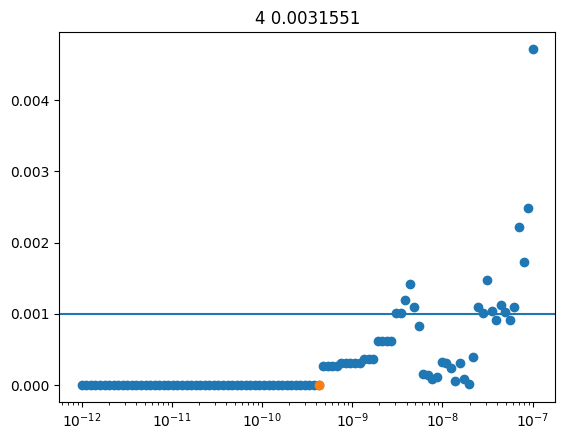

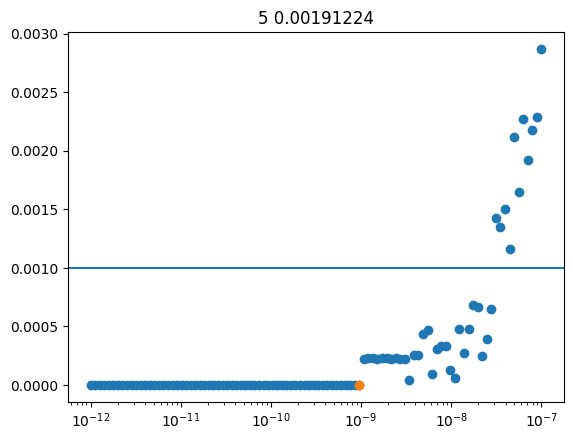

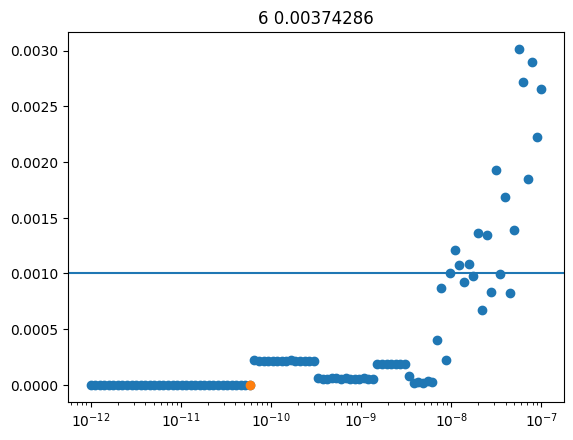

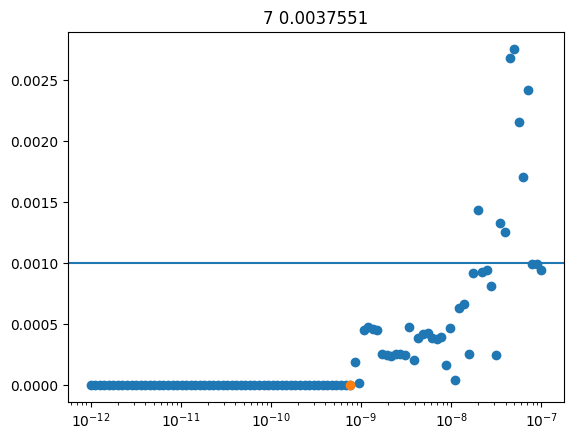

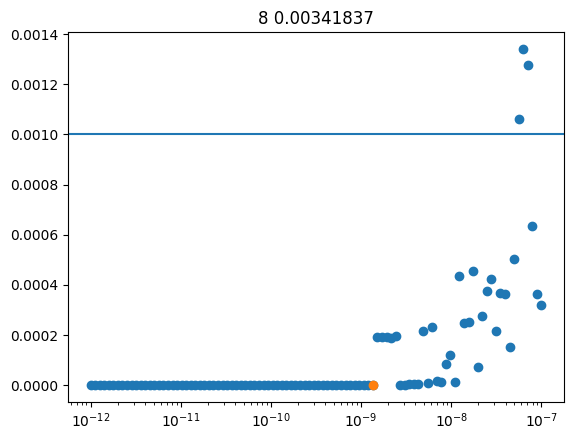

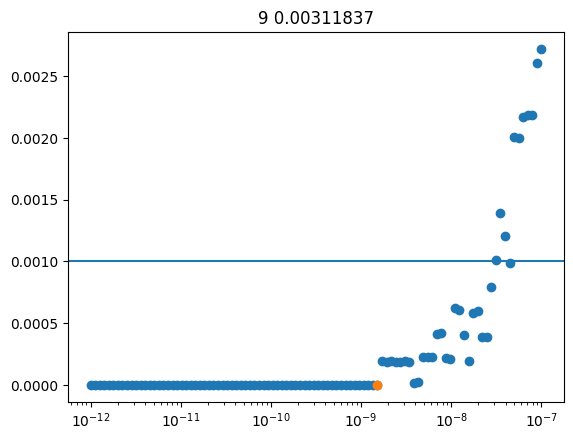

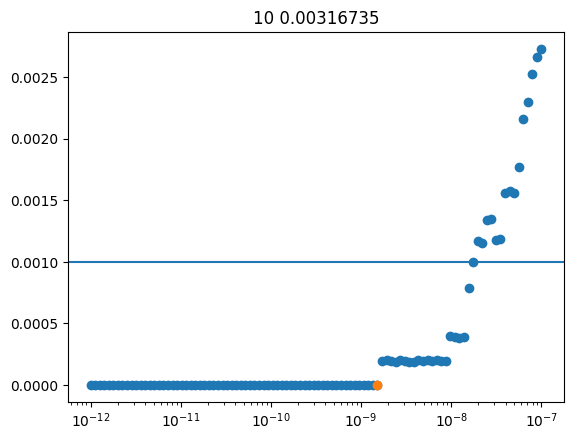

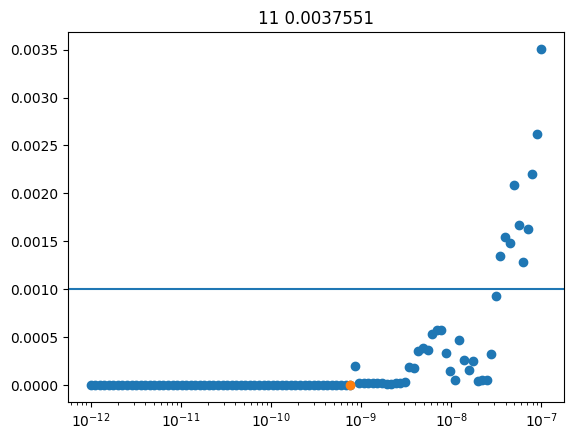

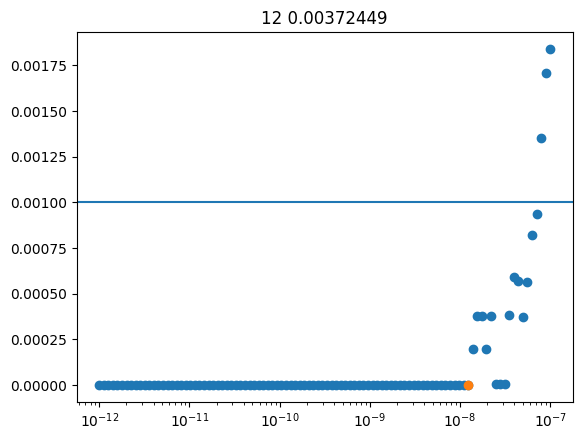

[6.33336281e-07 1.60573832e-06 7.11441866e-07 3.88609270e-08
 5.01908172e-07 1.13281664e-06 6.95085787e-08 8.97737815e-07
 1.60573832e-06 1.80376445e-06 1.80376445e-06 8.97737815e-07
 1.46308895e-05]


In [81]:
waists = data[:, :, 0, 0][:, 0]
differences = np.abs(data[:, :, 1, 1] - data[:, :, 0, 1]) * 1.66e-3
amplitudes = data[:, :, 0, 2]
idx = np.array([], dtype = int)
for i in range(len(waists)):
    mask = np.where(np.where(differences <= (noises[find_idx(f, 1.55e6)] * np.sqrt(1.55e6)))[0] == i)[0]
    zeros = [amplitudes[i][x] for x in np.where(differences <= (noises[find_idx(f, 1.55e6)] * np.sqrt(1.55e6)))[1][mask[0] : mask[-1]]]
    idx = np.append(idx, np.where(amplitudes[i] == np.max(zeros))[0])
print(np.array([amplitudes[i][idx[i]] for i in range(len(waists))]))
for i in range(len(waists)):
    plt.title(str(i) + " " + str(waists[i]))
    plt.axhline(1e-3)
    plt.scatter(amplitudes[i], differences[i])
    plt.scatter(amplitudes[i][idx[i]], differences[i][idx[i]])
    plt.xscale("log")
    plt.show()
NEPs = np.array([amplitudes[i][idx[i]] * 1500 * 985 / np.sqrt(1.55e6) for i in range(len(waists))])
print(NEPs)

352


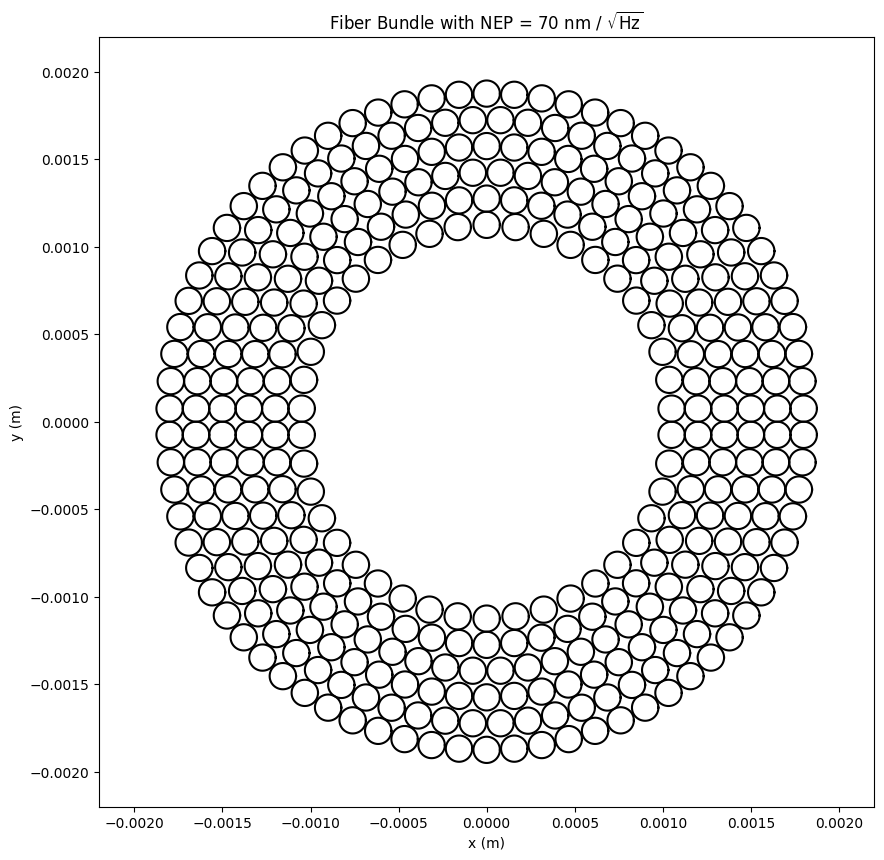

In [5]:
import fiber
import laser
import matplotlib.pyplot as plt
bundle = fiber.FiberBundle(2e-3, 2.5e-5, 5e-5)
# l = laser.Laser(waist = waists[7], power = 90, res = 2500)
bundle.drop_rings((0, 7))
print(bundle.count)
# fig, ax = bundle.plot(im = l, c = "k")
fig, ax = bundle.plot(c = "k")
ax.set_title(r"Fiber Bundle with NEP = 70 nm / $\sqrt{\text{Hz}}$")
plt.show()

In [7]:
import numpy as np
lmda = 1064e-9
waist = 3.2e-6
theta = lmda / np.pi / waist
print(f"beam diameter = {2 * (1.5e-3 * np.tan(theta) + waist) * 1e3:.3f} mm")

beam diameter = 0.325 mm


Bad pipe message: %s [b'\xa2\xd7\x1c\xaatU\x8e\x98\x15"{{\x02\x18\xd6:\xa3B\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E']
Bad pipe message: %s [b'\xa5\x84@\x881\xa0\xfd6\xdd8\xc1\xa9\xae\x9d\x8b\x17_\x90\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00', b'E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\

9
220


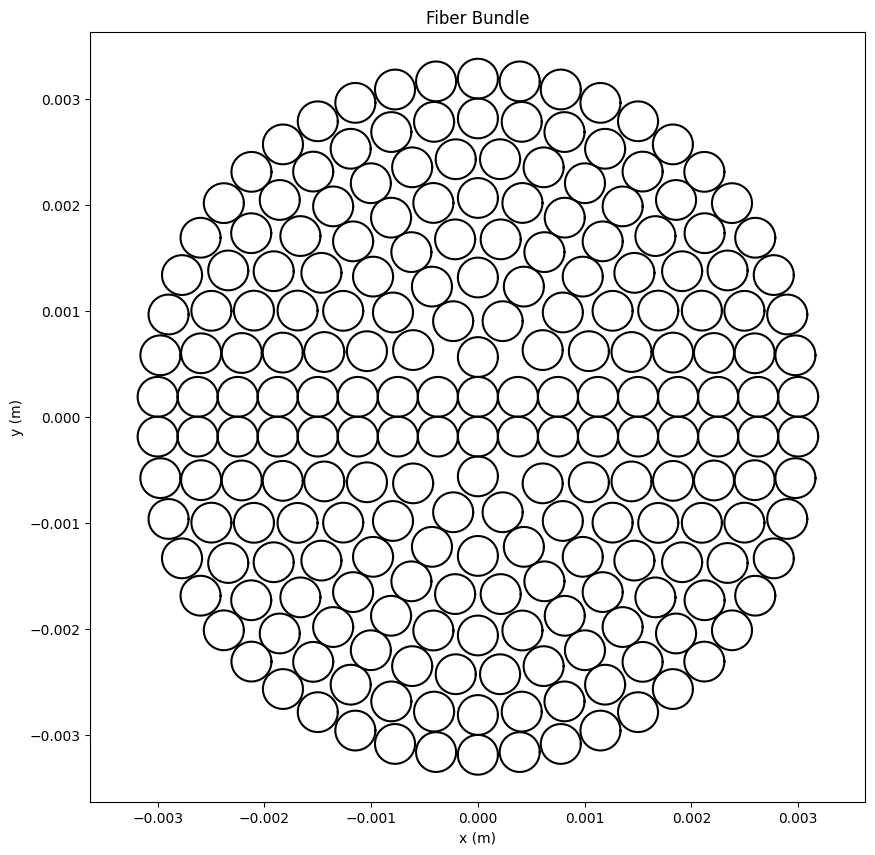

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Fiber Bundle'}, xlabel='x (m)', ylabel='y (m)'>)

Bad pipe message: %s [b'\xc4\x8a\xce\xa3k\xbfhG\xc5K\t\x18\xe1\xc21&\x18\xf5\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00', b'\x05\x00\x06']
Bad pipe message: %s [b"\xd8\xe5r\x13s6.\xc3'\x94\x0b\xed\x15\xce\xb9/\xad-\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00"]
Bad pipe message: %s [b"\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x0

In [16]:
import fiber
### 0-3, 3-6, 6-9
bundle = fiber.FiberBundle(3.3e-3, (250 / 2) * 1e-6, (125 / 2) * 1e-6)
print(len(bundle.fiber_rings))
# bundle.drop_rings((0, 5))
print(bundle.count)
bundle.plot(show = True, c = "k")

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import fiber
import laser
from joblib import Parallel, delayed
data = np.array([[]])
def gen_data(i, bundle):
    dat = np.array([])
    space = bundle.fiber_rings[i] - bundle.cladding
    bundle.drop_rings((0, i))
    for j in np.linspace(space, 2 * bundle.r, 50):
        l = laser.Laser(waist = j, power = 0.09)
        with open("data/20250624/" + str(np.round(l.waist, 5)) + "waist_" + str(i) + "bundlesdropped.csv") as f:
            file = csv.reader(f)
            file.__next__()
            dat = np.append(dat, np.array([*file], dtype = float)).reshape(-1, 3)
            f.close()
    bundle.reset()
    return dat
data = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_data)(i, fiber.FiberBundle(3.3e-3, (250 / 2) * 1e-6, (125 / 2) * 1e-6)) for i in range(0, 9))])
data = data.reshape(9, 50, 200, 3)
data[:, :, :, 1] /= 1000

In [3]:
maxes = np.array([])
for i in range(len(data)):
    for j in range(len(data[i])):
        maxes = np.append(maxes, np.max(np.abs(data[i][j][:, 1])))
maxes = maxes.reshape(len(data), 50)

In [5]:
def gen_headers(i, bundle):
    head = np.array([])
    space = bundle.fiber_rings[i] - bundle.cladding
    bundle.drop_rings((0, i))
    for j in np.linspace(space, 2 * bundle.r, 50):
        l = laser.Laser(waist = j, power = 0.09)
        with open("data/20250624/" + str(np.round(l.waist, 5)) + "waist_" + str(i) + "bundlesdropped.csv") as f:
            file = csv.reader(f)
            head = np.append(head, file.__next__())
            f.close()
    bundle.reset()
    return head
headers = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_headers)(i, fiber.FiberBundle(3.3e-3, (250 / 2) * 1e-6, (125 / 2) * 1e-6)) for i in range(0, 9))])
headers = headers.reshape(len(data), 50, -1)

In [6]:
w = np.array([])
for c in headers[:, :, 6]:
    for waist in c:
        w = np.append(w, float(waist[13:]))
w = w.reshape(len(data), 50)

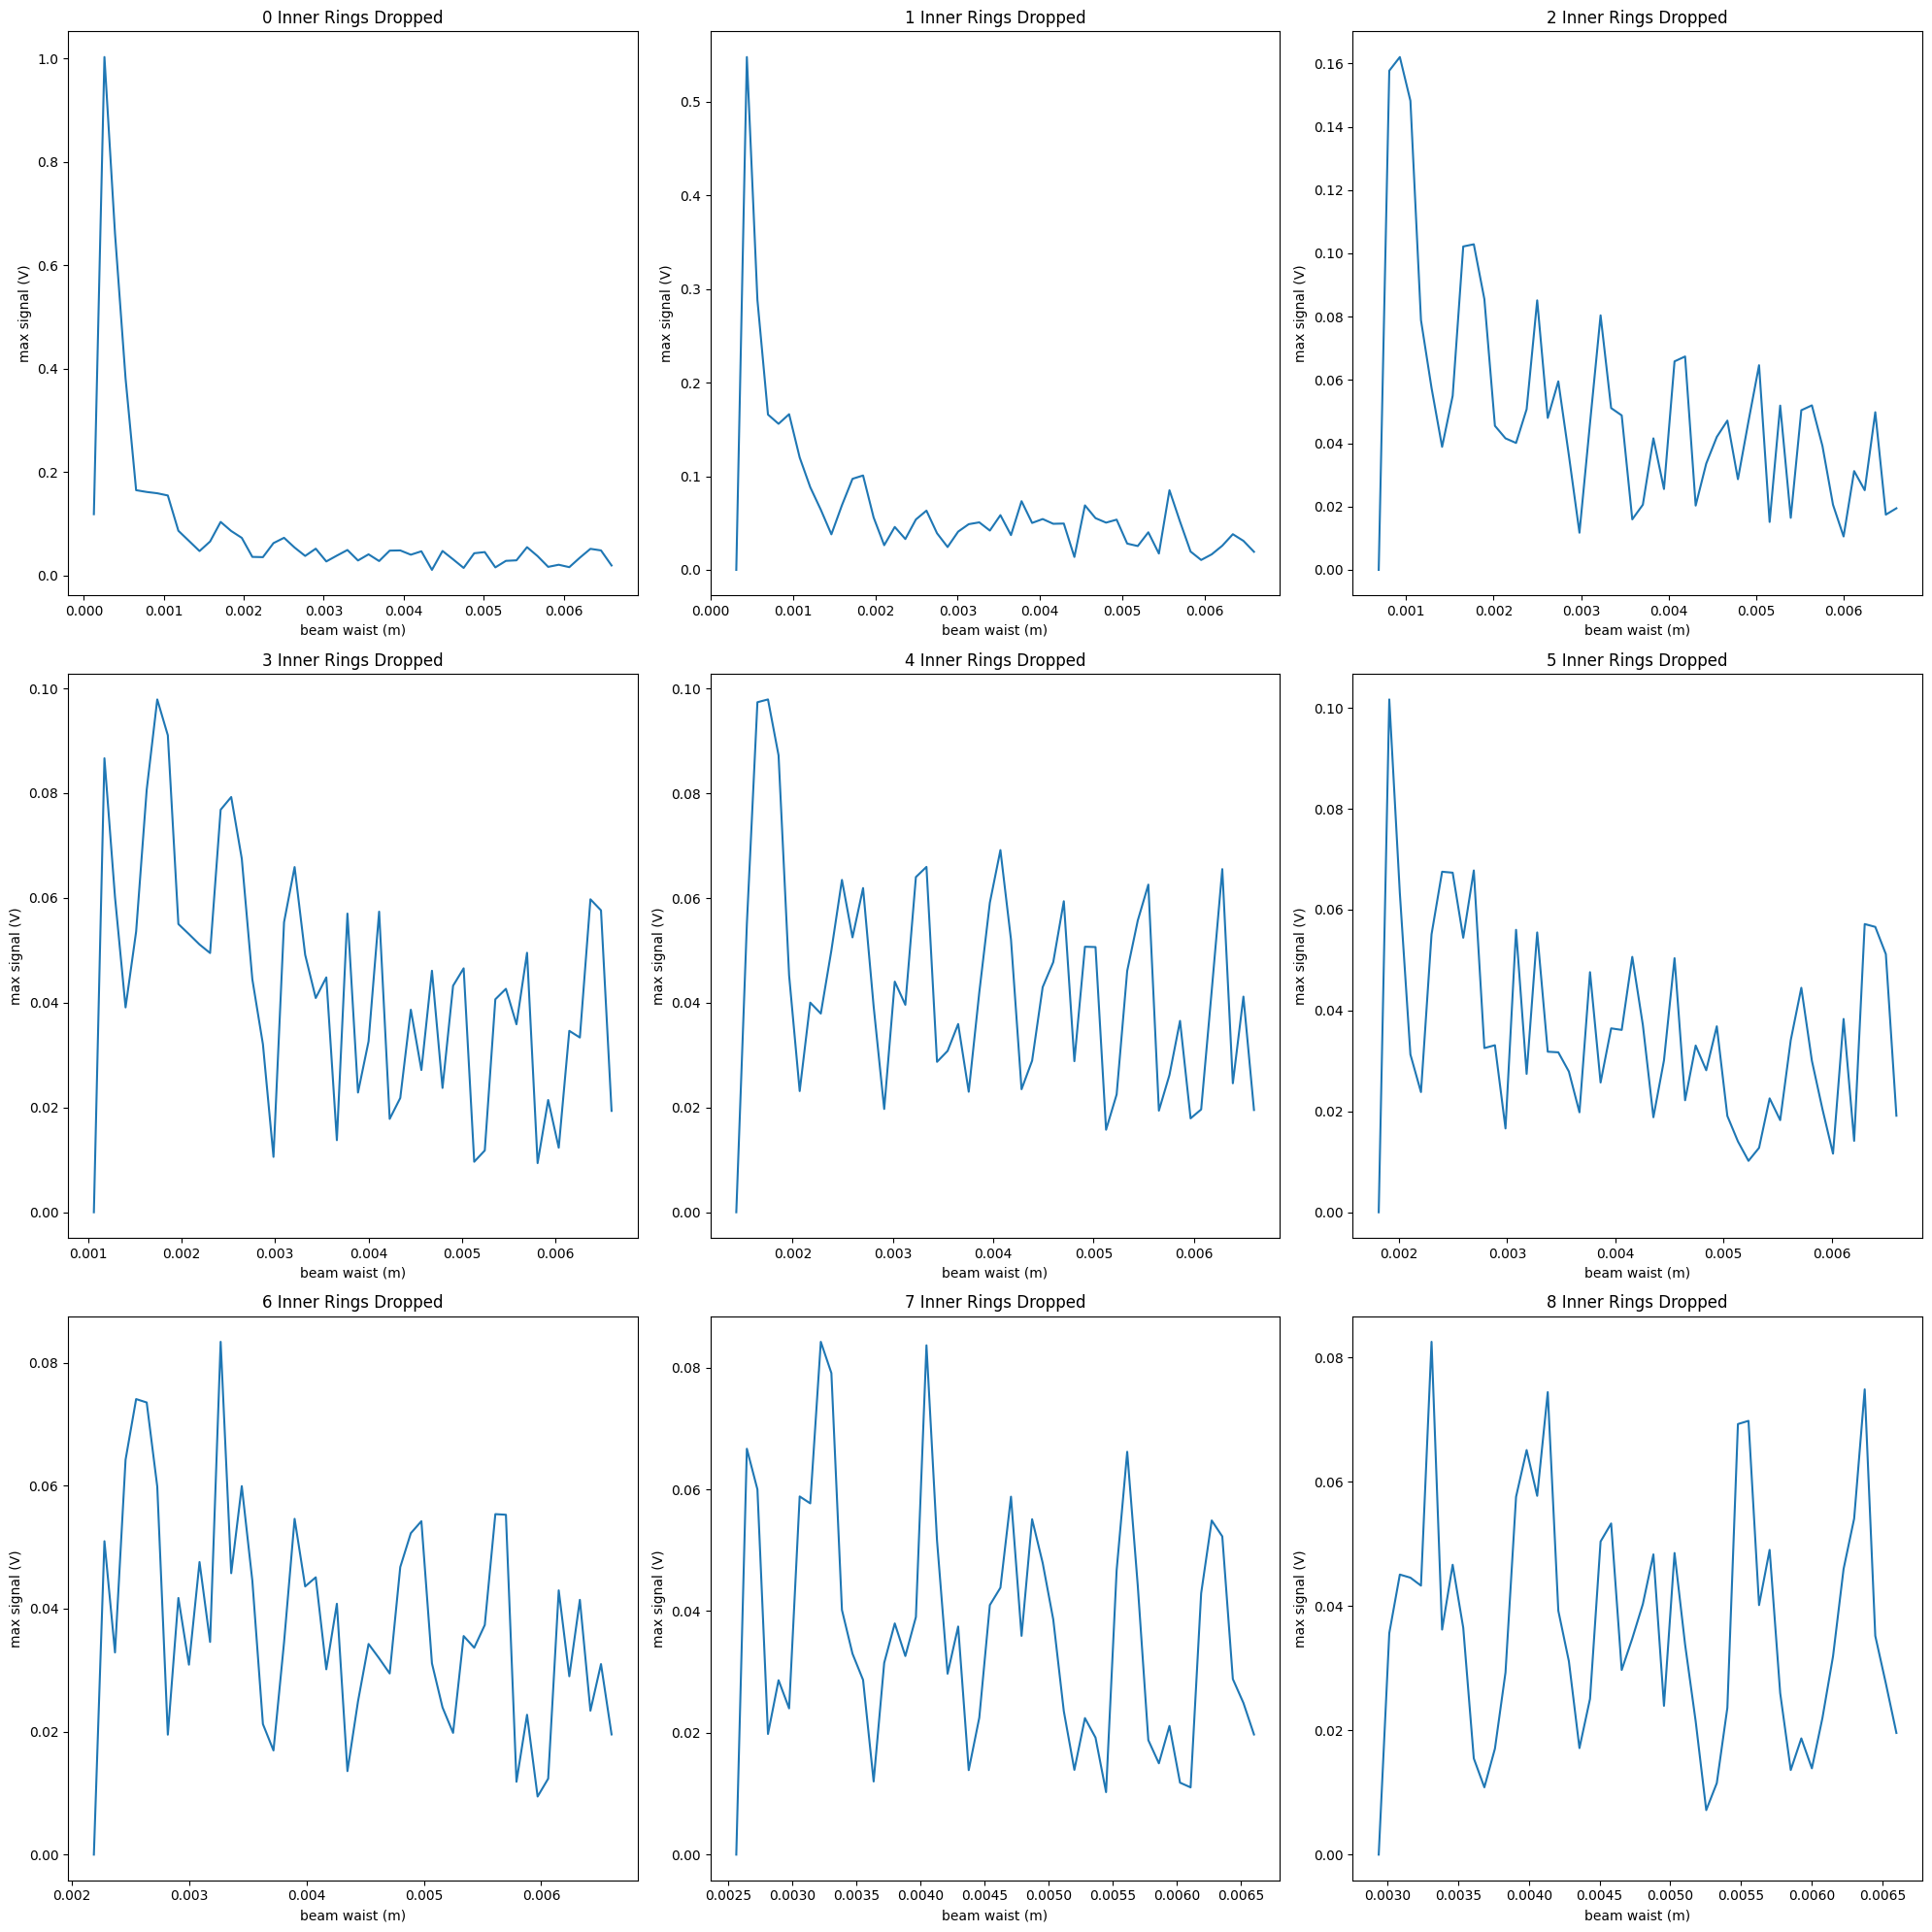

In [7]:
scale = 1668
fig, ax = plt.subplots(3, 3, figsize = (20, 20))
for i in range(len(data)):
    if i < 3:
        ax[0][i].plot(w[i], maxes[i] * scale, label = "rings dropped = " + str(i))
        ax[0][i].set_xlabel("beam waist (m)")
        ax[0][i].set_ylabel("max signal (V)")
        ax[0][i].set_title(str(i) + " Inner Rings Dropped")
    elif i < 6:
        ax[1][i - 3].plot(w[i], maxes[i] * scale, label = "rings dropped = " + str(i))
        ax[1][i - 3].set_xlabel("beam waist (m)")
        ax[1][i - 3].set_ylabel("max signal (V)")
        ax[1][i - 3].set_title(str(i) + " Inner Rings Dropped")
    else:
        ax[2][i - 6].plot(w[i], maxes[i] * scale, label = "rings dropped = " + str(i))
        ax[2][i - 6].set_xlabel("beam waist (m)")
        ax[2][i - 6].set_ylabel("max signal (V)")
        ax[2][i - 6].set_title(str(i) + " Inner Rings Dropped")
plt.tight_layout()
plt.show()

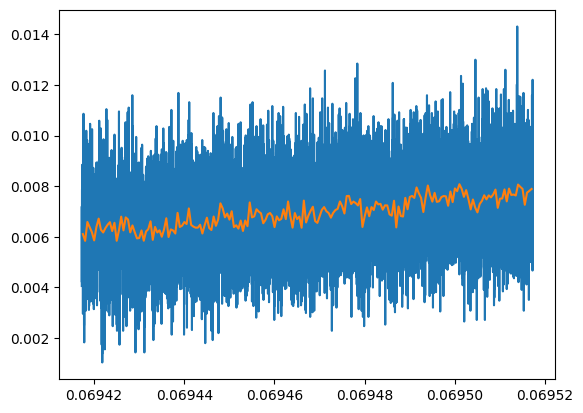

In [8]:
import sys
import os
from nptdms import TdmsFile
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    # Returns a list of args, and traces
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        # print("Reading ", folder_name, str(i))
        # print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }
def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    # print("Sample rate is " + str(sample_rate))
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    ret = np.mean(series.reshape(-1, bin_size), axis=1)
    return ret

traces = check_and_load_or_process(176, "../data/sample_noise/", "X", 1, 5)
times = np.arange(0, len(traces[0]['series'])) * (1 / TdmsFile.read("../data/sample_noise/iter_176.tdms")["main"].properties.get("r", None))
mx_t = times[-1] * np.random.rand()
trace = int(np.round(np.random.rand() * 4))
plt.plot(times[find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], traces[trace]["series"][find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)])
plt.plot(bin_data(times[find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], 100), bin_data(traces[trace]["series"][find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], 100))
plt.show()

In [9]:
from scipy.signal import periodogram
def gen_freqs(i, j):
    return periodogram(data[i][j][:, 1] * scale, 2e6, nfft = len(data[i][j][:, 1]))[0]
def gen_sigs(i, j):
    return periodogram(data[i][j][:, 1] * scale, 2e6, nfft = len(data[i][j][:, 1]))[1]
def gen_noises(i, j, mx_t, trace):
    return periodogram(bin_data(traces[trace]["series"][find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], 100), 2e6, nfft = len(data[i][j][:, 1]))[1]
def gen_psds(i, j, mx_t, trace):
    return periodogram(data[i][j][:, 1] * scale + bin_data(traces[trace]["series"][find_nearest(times, mx_t - 1e-4):find_nearest(times, mx_t)], 100), 2e6, nfft = len(data[i][j][:, 1]))[1]
mx_t = ((times[-1] - 1e-4) * np.random.rand()) + 1e-4
trace = int(np.round(np.random.rand() * 4))
sigs = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_sigs)(i, j) for i in range(len(data)) for j in range(len(data[i])))])
noises = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_noises)(i, j, mx_t, trace) for i in range(len(data)) for j in range(len(data[i])))])
freqs= np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_freqs)(i, j) for i in range(len(data)) for j in range(len(data[i])))])
psds = np.array([Parallel(n_jobs = -1, backend = "threading")(delayed(gen_psds)(i, j, mx_t, trace) for i in range(len(data)) for j in range(len(data[i])))])
freqs = freqs.reshape(len(data), 50, -1)
psds = psds.reshape(len(data), 50, -1)
sigs = sigs.reshape(len(data), 50, -1)
noises = noises.reshape(len(data), 50, -1)

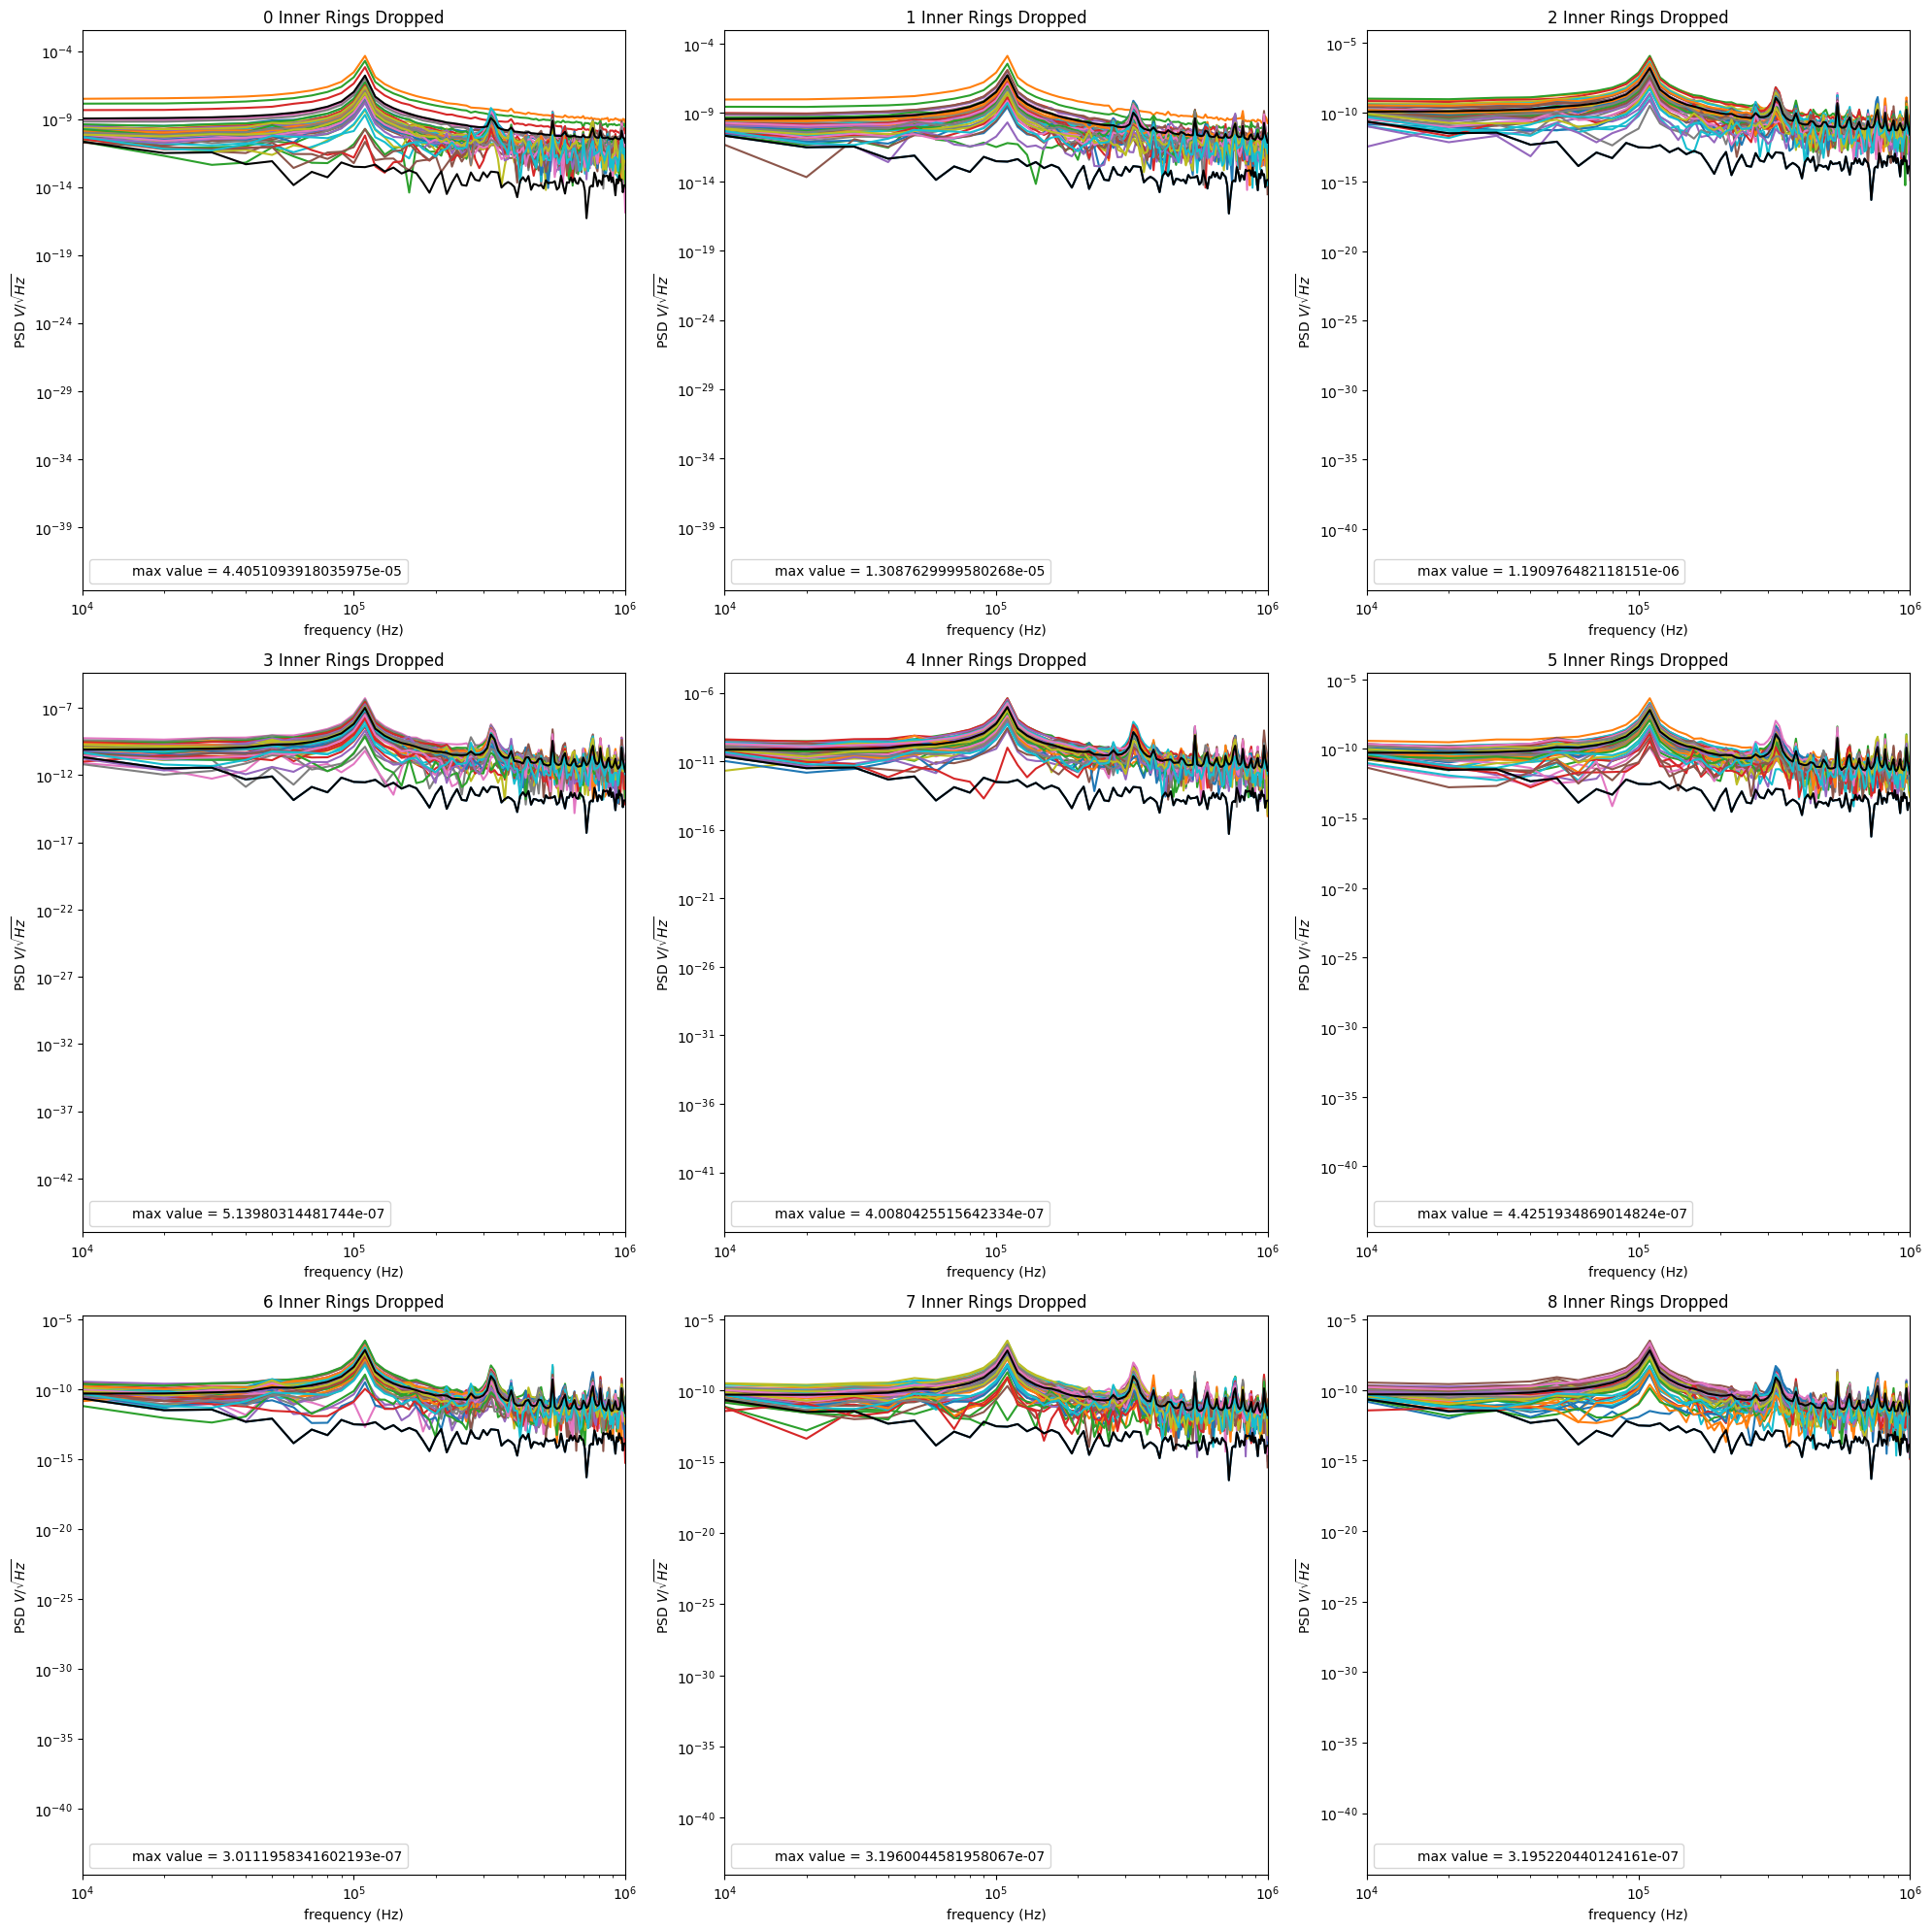

In [10]:
import matplotlib
fig, ax = plt.subplots(3, 3, figsize = (20, 20))
for i in range(len(data)):
    for j in range(len(psds[i])):
        if i < 3:
            ax[0][i].loglog(freqs[i][j], psds[i][j])
        elif i < 6:
            ax[1][i - 3].loglog(freqs[i][j], psds[i][j])
        else:
            ax[2][i - 6].loglog(freqs[i][j], psds[i][j])
    if i < 3:
        # ax[0][i].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(psds[:], axis = 1)[i], c = "k")
        ax[0][i].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(sigs[:], axis = 1)[i], c = "k")
        ax[0][i].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(noises[:], axis = 1)[i], c = "k")
        ax[0][i].set_title(str(i) + " Inner Rings Dropped")
        ax[0][i].set_xlabel("frequency (Hz)")
        ax[0][i].set_ylabel(r"PSD $V / \sqrt{Hz}$")
        ax[0][i].set_xlim(1e4, 1e6)
        # ax[0][i].set_ylim(1e-15, 1e-4)
        r = matplotlib.patches.Rectangle((0,0), 0.001, 0.001, fill=False, edgecolor='none', visible=False)
        ax[0][i].legend([r], ["max value = " + str(np.max(psds[i]))])
    elif i < 6:
        # ax[1][i - 3].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(psds[:], axis = 1)[i], c = "k")
        ax[1][i - 3].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(sigs[:], axis = 1)[i], c = "k")
        ax[1][i - 3].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(noises[:], axis = 1)[i], c = "k")
        ax[1][i - 3].set_title(str(i) + " Inner Rings Dropped")
        ax[1][i - 3].set_xlabel("frequency (Hz)")
        ax[1][i - 3].set_ylabel(r"PSD $V / \sqrt{Hz}$")
        ax[1][i - 3].set_xlim(1e4, 1e6)
        # ax[1][i - 3].set_ylim(1e-15, 1e-4)
        r = matplotlib.patches.Rectangle((0,0), 0.001, 0.001, fill=False, edgecolor='none', visible=False)
        ax[1][i - 3].legend([r], ["max value = " + str(np.max(psds[i]))])
    else:
        # ax[2][i - 6].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(psds[:], axis = 1)[i], c = "k")
        ax[2][i - 6].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(sigs[:], axis = 1)[i], c = "k")
        ax[2][i - 6].loglog(np.mean(freqs[:], axis = 1)[i], np.mean(noises[:], axis = 1)[i], c = "k")
        ax[2][i - 6].set_title(str(i) + " Inner Rings Dropped")
        ax[2][i - 6].set_xlabel("frequency (Hz)")
        ax[2][i - 6].set_ylabel(r"PSD $V / \sqrt{Hz}$")
        ax[2][i - 6].set_xlim(1e4, 1e6)
        # ax[2][i - 6].set_ylim(1e-15, 1e-4)
        r = matplotlib.patches.Rectangle((0,0), 0.001, 0.001, fill=False, edgecolor='none', visible=False)
        ax[2][i - 6].legend([r], ["max value = " + str(np.max(psds[i]))])
plt.tight_layout()
plt.show()

In [11]:
snrs = np.array([])
for i in range(0, len(data)):
    for j in range(len(sigs[i])):
        if np.sum(sigs[i][j]) == 0:
            snrs = np.append(snrs, 0)
        else:
            snrs = np.append(snrs, 10 * np.log10(np.sum(sigs[i][j]) / np.sum(noises[i][j])))
snrs = snrs.reshape(len(data), 50)

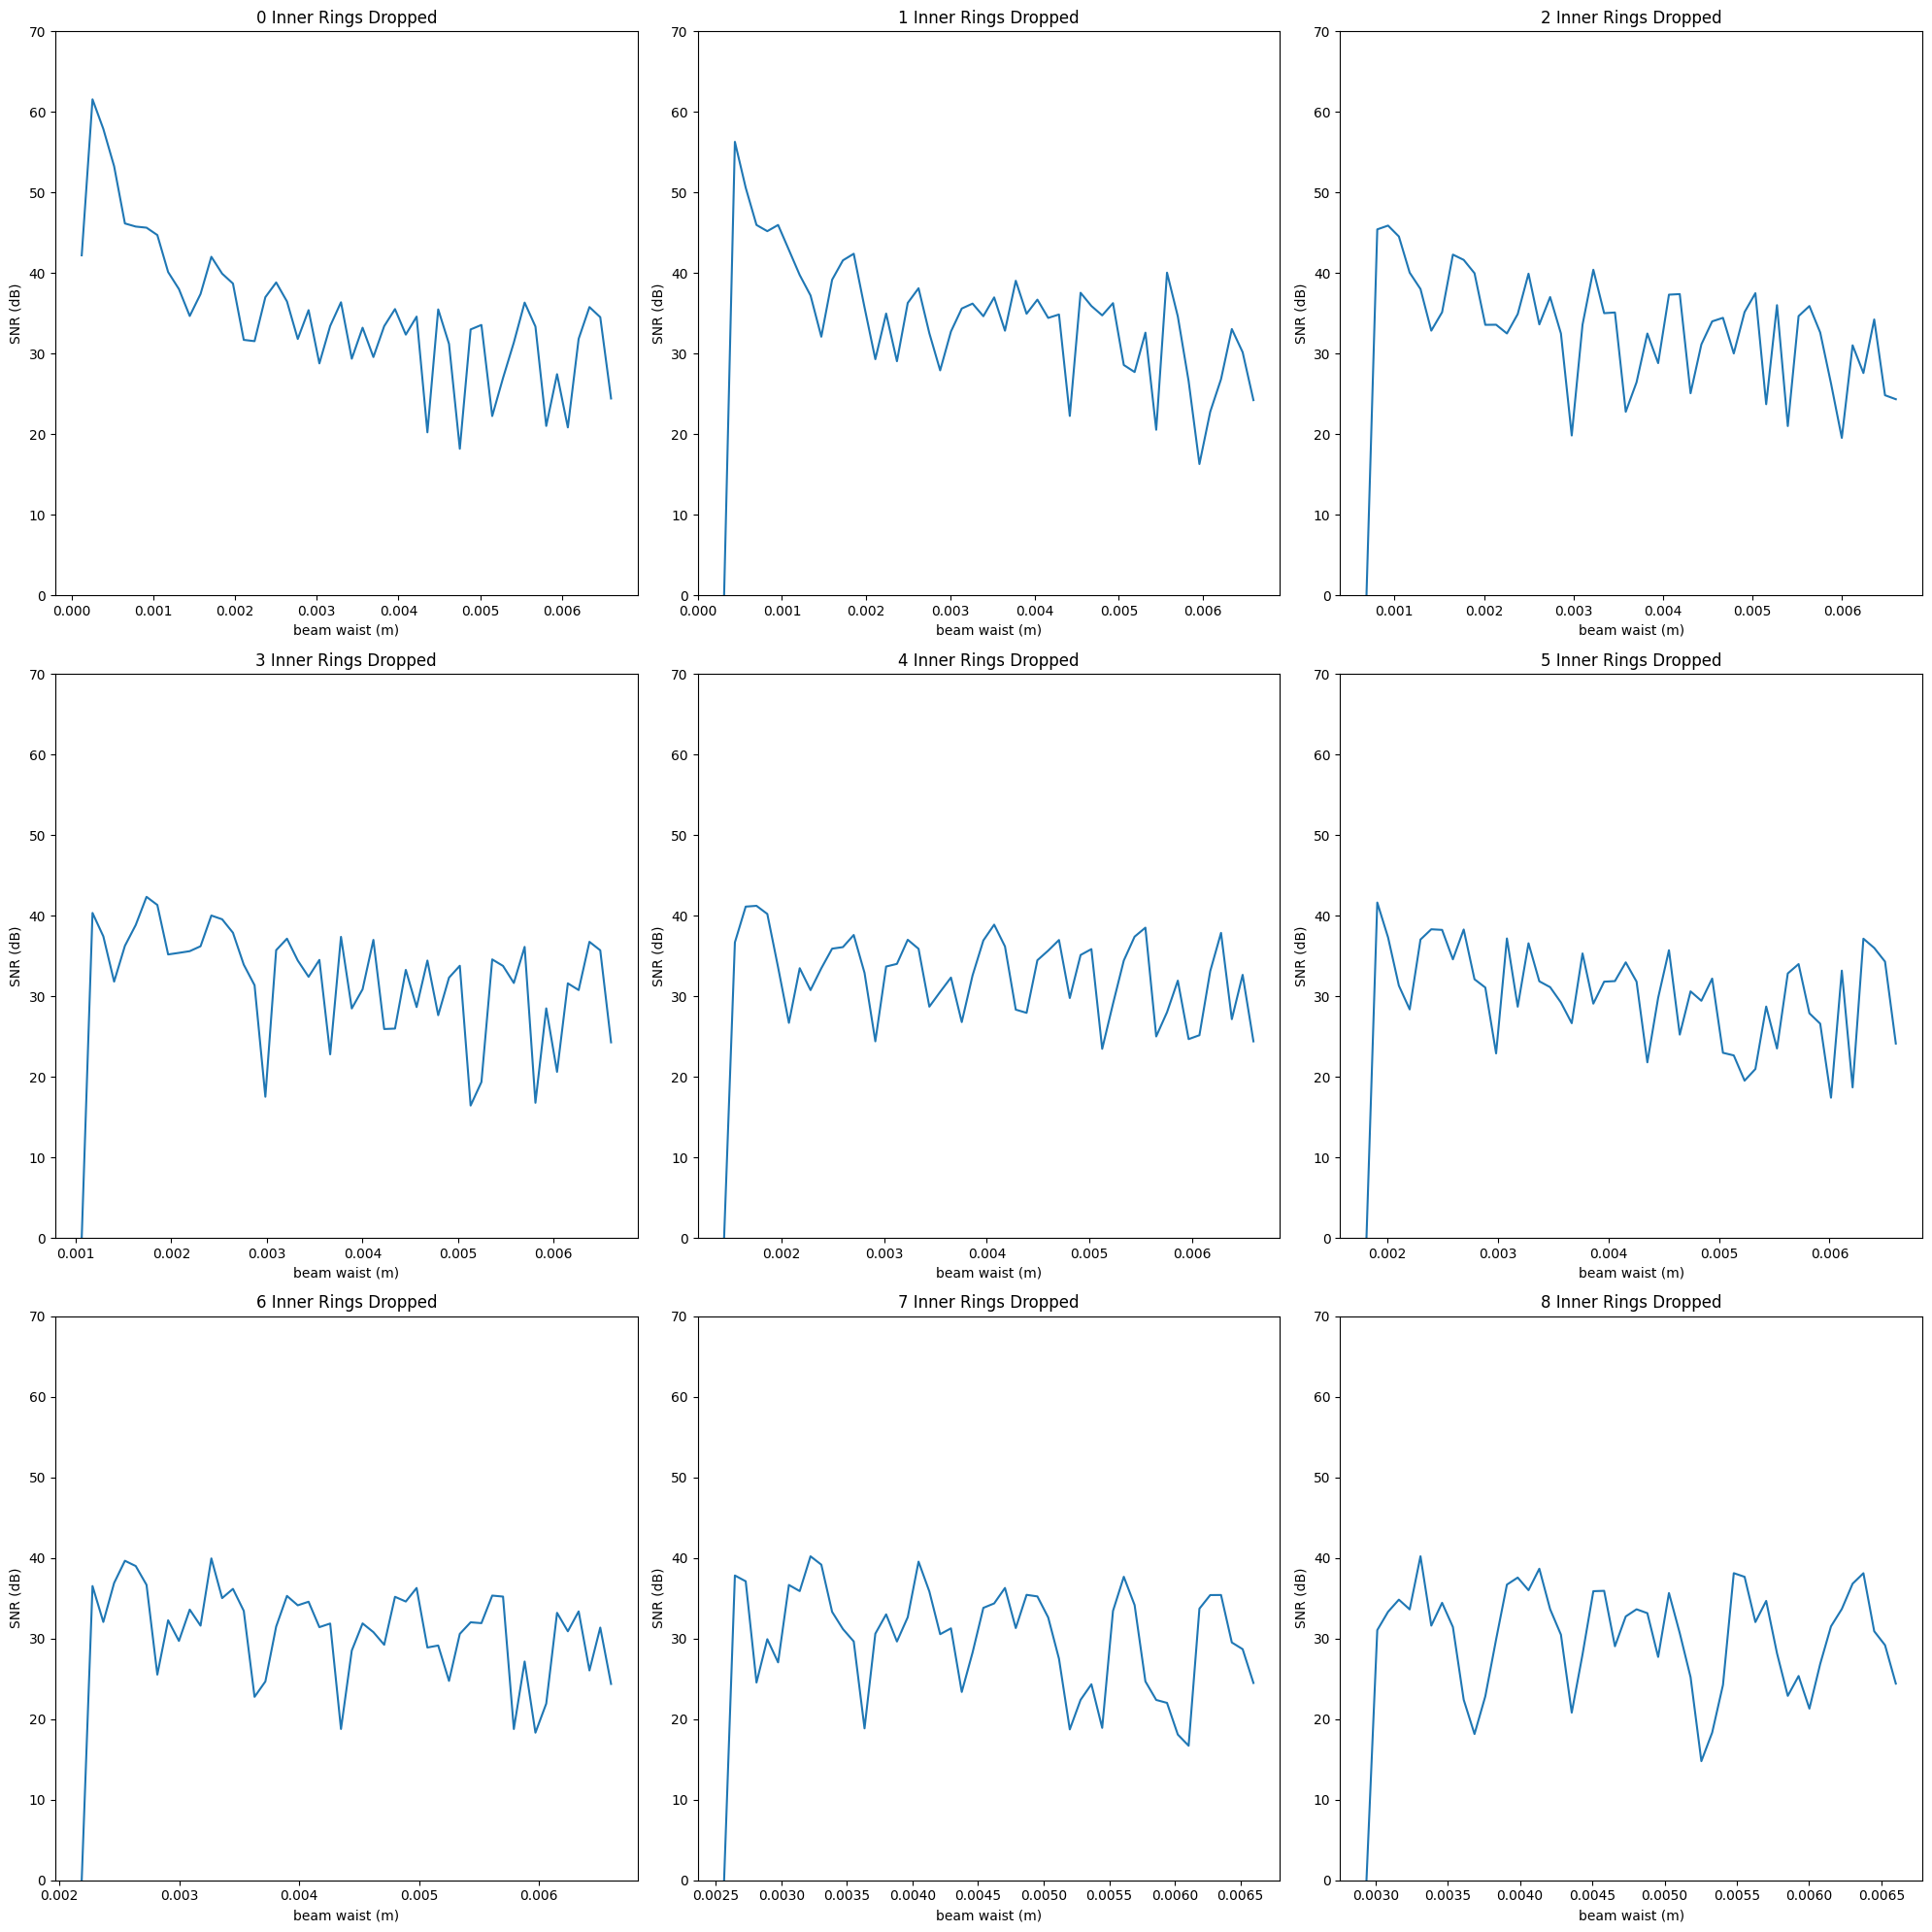

In [12]:
best_snr_waist = np.array([])
fig, ax = plt.subplots(3, 3, figsize = (20, 20))
for i in range(len(data)):
    best_snr_waist = np.append(best_snr_waist, w[i][np.where(snrs[i] == np.max(snrs[i]))[0]])
    if i < 3:
        ax[0][i].plot(w[i], snrs[i])
        ax[0][i].set_xlabel("beam waist (m)")
        ax[0][i].set_ylabel("SNR (dB)")
        ax[0][i].set_title(str(i) + " Inner Rings Dropped")
        ax[0][i].set_ylim(0, 70)
    elif i < 6:
        ax[1][i - 3].plot(w[i], snrs[i])
        ax[1][i - 3].set_xlabel("beam waist (m)")
        ax[1][i - 3].set_ylabel("SNR (dB)")
        ax[1][i - 3].set_title(str(i) + " Inner Rings Dropped")
        ax[1][i - 3].set_ylim(0, 70)
    else:
        ax[2][i - 6].plot(w[i], snrs[i])
        ax[2][i - 6].set_xlabel("beam waist (m)")
        ax[2][i - 6].set_ylabel("SNR (dB)")
        ax[2][i - 6].set_title(str(i) + " Inner Rings Dropped")
        ax[2][i - 6].set_ylim(0, 70)
plt.tight_layout()
plt.show()

[0.00025714 0.00044082 0.00092883 0.00174056 0.00175357 0.0019102
 0.00326811 0.00322168 0.00331122]


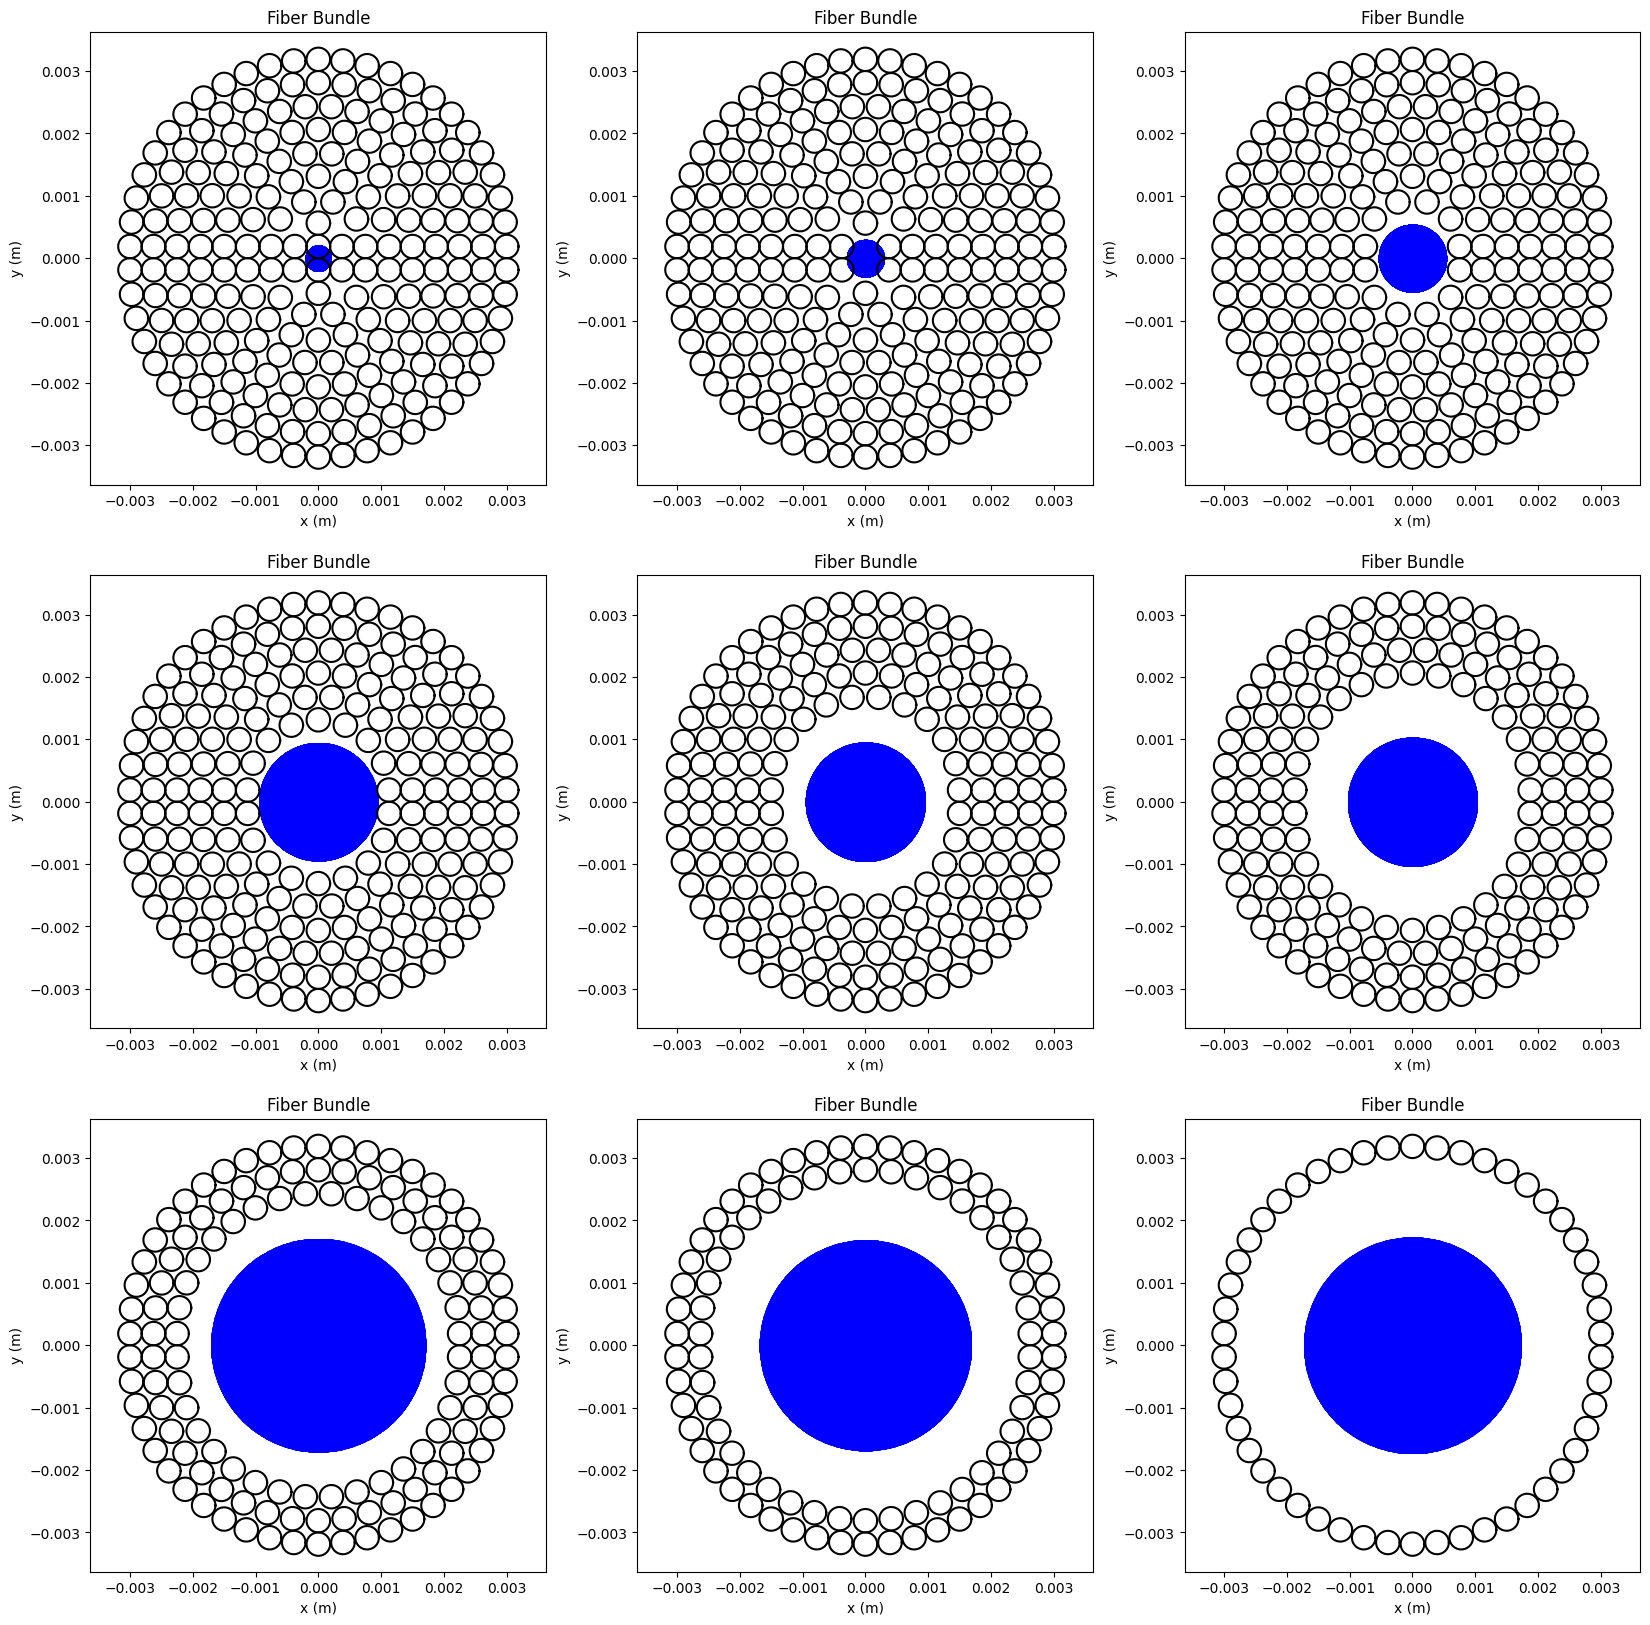

In [13]:
fig, ax = plt.subplots(3, 3, figsize = (20, 20))
print(best_snr_waist)
for i in range(len(data)):
    bundle = fiber.FiberBundle(3.3e-3, (250 / 2) * 1e-6, (125 / 2) * 1e-6)
    bundle.drop_rings((0, i))
    l = laser.Laser(waist = best_snr_waist[i], power = 90)
    bundle.plot(ax = ax[i // 3][i % 3], im = l, c = "k")
plt.show()

[0.0001875 0.000375  0.00075   0.001125  0.0015    0.001875  0.00225
 0.002625  0.003    ]


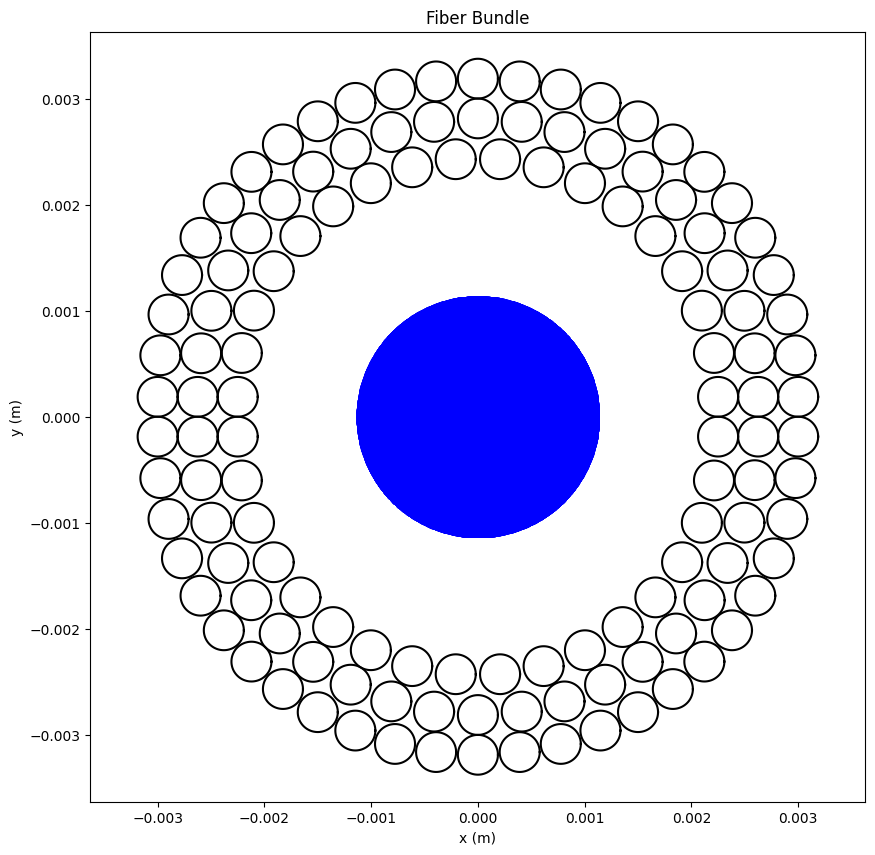

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Fiber Bundle'}, xlabel='x (m)', ylabel='y (m)'>)

In [14]:
bundle = fiber.FiberBundle(3.3e-3, (250 / 2) * 1e-6, (125 / 2) * 1e-6)
print(bundle.fiber_rings)
space = bundle.fiber_rings[6] - bundle.cladding
bundle.drop_rings((0, 6))
bundle.plot(im = laser.Laser(waist = space, power = 90), show = True, c = "k")

In [21]:
print(best_snr_waist)

[0.00025714 0.00044082 0.00092883 0.00174056 0.00175357 0.0019102
 0.00326811 0.00322168 0.00331122]


0.00085
480
388


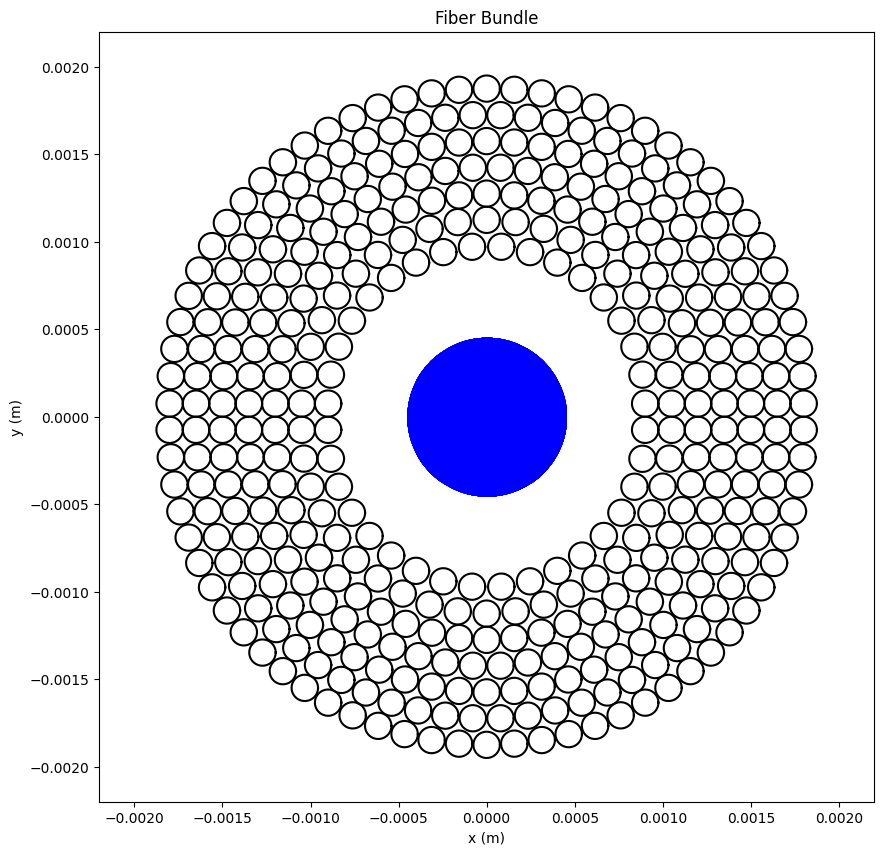

0.0


In [8]:
import fiber
import laser
bundle = fiber.FiberBundle(2e-3, 2.5e-5, 5e-5)
i = 6
space = bundle.fiber_rings[i] - bundle.cladding
print(len(bundle.centers))
bundle.drop_rings((0, i))
print(len(bundle.centers))
bundle.plot(im = laser.Laser(waist = space, power = 0), show = True, c = "k")
print(bundle.sum_power(laser.Laser(waist = space, power = 0)))